In [14]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from plotting_functions import *
import math
import csv
import time
from math import log
import networkx as nx
from os import listdir
import random
import io
from io import StringIO
import codecs
import math
from os.path import isfile, join
#from geopy.distance.geodesic import vincenty
# In[2]:
from math import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition

In [15]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

# geometric distribution for trials prob(n) = p q^(n-1) where p is success probability
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
# photon transmission probability in fiber (i.e., 0.2dB/km)
Trans = lambda x: 10**(-0.2*x/10)
# Binary Shanon entropy
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

In [ ]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware


def T_sequential_cutoff2(τ_cut,τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    # implementing the recursion relation :
    ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
    p1 = p_link*Trans(links[0])
    T_tot = 2*τs[0]/p1
    for i_l in np.arange(1,len(links)):
        L = links[i_l]
        m_n = int(τ_cut/(2*τs[i_l]))
        p_n = p_link*Trans(L)
        Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
        Pm = 1- (1-p_n)**m_n
        T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    m_arr = np.floor(τ_cut/(2*τs))
    Pm_arr = 1- (1-p_link*Trans(links))**m_arr
    f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    print("f_e2e_qkd",f_e2e_qkd)
    f_e2e_qkd = 0.6095738302575425
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    raw_rate = 1.6519930671093899

    # analytical,seq,raw rate,n=3 point 150.0 1.6519930671093899
    # analytical,seq,F,n=3 point 150.0 0.6095738302575425
    # analytical,seq,skr,n=3 point 150.0 0.05769747652734004
    
    skr = raw_rate * (1-h([ex])-h([ez]))
    print("skr is ",skr)
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    # skr, F_e2e = 0, 0
    return raw_rate, skr, F_e2e
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Ls = [400/(3+1)]*(3+1)
τ_coh = 0.1 # coherence time [sec]
τ_cut = 150/1000
raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff2(τ_cut,τ_coh, mu_link, F_link, Ls)
# print("raw_rate_seq, skr_seq, Fe2e_seq ",raw_rate_seq, skr_seq, Fe2e_seq )
skr_seq = skr_seq[0]


In [ ]:
avg_e2e_f = 0.6095738302575425
def h2(e_x):
    return -e_x*math.log2(e_x)-(1-e_x)*math.log2(1-e_x)
mu_e2e=(self.mu**n)*np.prod(self.mu_i[self.path_id])

e_x =(1+mu_e2e)/2-(mu_e2e*avg_e2e_f)
e_z=(1-mu_e2e)/2
r= 1-self.h2(e_x)-self.h2(e_z)
S = rate*r
print(S)

In [ ]:
analytical,seq,raw rate,n=3 point 150.0 1.6519930671093899
analytical,seq,F,n=3 point 150.0 0.5350374529022418

In [16]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware


def T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    # implementing the recursion relation :
    ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
    p1 = p_link*Trans(links[0])
    T_tot = 2*τs[0]/p1
    for i_l in np.arange(1,len(links)):
        L = links[i_l]
        m_n = int(τ_cut/(2*τs[i_l]))
        p_n = p_link*Trans(L)
        Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
        Pm = 1- (1-p_n)**m_n
        T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    m_arr = np.floor(τ_cut/(2*τs))
    Pm_arr = 1- (1-p_link*Trans(links))**m_arr
    f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    # skr, F_e2e = 0, 0
    return raw_rate, skr,F_e2e# f_e2e_qkd

In [17]:
def get_analytical_results_with_cut_off(R,Le2e,τ_cut):
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

    n = 3 # number of segments (i.e., no. of repeaters -1 )
    Ls = [Le2e/(R+1)]*(R+1)
    τ_coh = 0.1 # coherence time [sec]
    raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    # print("raw_rate_seq, skr_seq, Fe2e_seq ",raw_rate_seq, skr_seq, Fe2e_seq )
    skr_seq = skr_seq[0]
    each_scheme_cutoff_result = {}
    
    try:
        each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_seq
    except:
            each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)]={}
            each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_seq
    try:
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)][τ_cut*1000] = skr_seq
    except:
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)]={}
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)][τ_cut*1000] = skr_seq
    try:
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)][τ_cut*1000] = Fe2e_seq
    except:
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)] ={}
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)][τ_cut*1000] = Fe2e_seq
    return each_scheme_cutoff_result

In [ ]:
def sequential_parallel_for_one_repeater(R,cut_off):
    c = 2e5 # speed of light in fiber [km/s]
    p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
    def T_parallel_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link, Nmax=100000):
        """ calculates the performance of parallel scheme with one repeater
        inputs:
            L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            Nmax: ensemble size for averaging
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        Nmax = int(Nmax) # to make sure Nmax is an integer
        τ1 = L1/c
        τ2 = L2/c
        p1 = p_link*Trans(L1)
        p2 = p_link*Trans(L2)
        N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
        N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
        Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0) # swap moment
        t1L = Ts-(2*N1-1)*τ1 # elapsed time of leftside repeater's memory 
        t1R = Ts-2*(N2-1)*τ2 # elapsed time of rightside repeater's memory 
        indsL = np.argwhere( t1L <= τ_cut )[:,0]
        indsR = np.argwhere( t1R <= τ_cut )[:,0]
        succ_inds = np.intersect1d(indsL,indsR)
        T_succ = np.sum(Ts[succ_inds]+ τ1) 
        fail_inds = list(set(list(range(Nmax)))-set(succ_inds))
        # L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 ).shape[0]
        # R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 ).shape[0]
        # T_fail = (2*τ1/p1 + τ_cut)*L_runs + (2*τ2*(1/p2-1)+τ1 + τ_cut)*R_runs
        # T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))
        L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 )[:,0]
        R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 )[:,0]
        # print(list(np.array(fail_inds)[L_runs]))
        left_mem_on_idx = list(np.array(fail_inds)[L_runs])
        right_mem_on_idx = list(np.array(fail_inds)[R_runs])
        T_elapsed_left = 2*N1[left_mem_on_idx]*τ1 + τ_cut
        T_elapsed_right = 2*(N2[right_mem_on_idx]-1)*τ2 +τ1+ τ_cut
        T_fail = np.sum(T_elapsed_left)+np.sum(T_elapsed_right)
    
        mean_succ =  T_succ/len(succ_inds)
        mean_fail = T_fail/len(fail_inds)
        # print("Mean succ time: ", T_succ/len(succ_inds))
        # print("Mean fail time: ", T_fail/len(fail_inds))
        # print("success prob", len(succ_inds)/Nmax)
        # print("fail prob", len(fail_inds)/Nmax)
    
        raw_rate = len(succ_inds)/(T_succ+T_fail)
        t_idle_qkd = t1L + t1R
        f_memory_qkd = np.mean(np.exp(- t_idle_qkd[succ_inds]/τ_coh) )
        N_links = 2
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        tA = Ts+ τ1 -2*(N1-1)*τ1 # elapsed time of A's memory 
        tB = Ts+ τ1 -(2*N2-1)*τ2 # elapsed time of B's memory 
        t_idle_bell = tA + tB + t1L + t1R
        mean_sender = tA[succ_inds].mean()
        mean_receiver = tB[succ_inds].mean()
        f_memory_bell = np.mean(np.exp(- t_idle_bell[succ_inds]/τ_coh) )
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        
        # print(f"t1L = {np.mean(t1L)}, t1R = {np.mean(t1R)}")
        # print(f"t1L = {np.mean(t1L[succ_inds])}, t1R = {np.mean(t1R[succ_inds])}")
        return raw_rate, skr, F_e2e, mean_succ, mean_fail, mean_sender, mean_receiver
    
    def T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link):
        """ calculates the performance of parallel scheme with one repeater
        inputs:
            L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        τ1 = L1/c
        τ2 = L2/c
        m = int(τ_cut/(2*τ2))
        p1 = p_link*Trans(L1)
        p2 = p_link*Trans(L2)
        # Q2m = (1-p2)**m
        P2m = 1- (1-p2)**m
        Nm = lambda x: (1-(1+m*x)*(1-x)**m)/x
        Tm = 2*τ1/(p1*P2m) +  (1/P2m-1)*τ_cut +Nm(p2)/P2m*2*τ2 
    
        raw_rate = 1/(Tm)
        # t1L = Nm(p2)/P2m*2*τ2
        # t1R = 2*τ2
        f_memory_qkd = p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-2*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-2*τ2/τ_coh) ) 
        N_links = 2
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        τe2e = τ1 + τ2
        f_memory_bell = np.exp(-3*τe2e/τ_coh) *p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-4*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-4*τ2/τ_coh) ) 
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        
        return raw_rate, skr, F_e2e


    
    Le2e = 250 # e2e distance [km]
    τ_coh = 0.1
    τ_cut = cut_off
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    
    δ = 0.1
    rep_loc = np.linspace(δ,1-δ,40)
    raw_rate_par = np.zeros(len(rep_loc))
    skr_par = np.zeros(len(rep_loc))
    Fe2e_par = np.zeros(len(rep_loc))
    raw_rate_seq = np.zeros(len(rep_loc))
    skr_seq = np.zeros(len(rep_loc))
    Fe2e_seq = np.zeros(len(rep_loc))
    
    # for i, pos in enumerate(rep_loc):
    L1 = 125
    L2 = 125
    raw_rate_par, skr_par, Fe2e_par,_,_,_,_ = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link, Nmax=1e6)
    raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link)


    each_scheme_cutoff_result = {}
    
    try:
        each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_seq
    except:
            each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)]={}
            each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_seq
    try:
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)][τ_cut*1000] = skr_seq
    except:
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)]={}
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)][τ_cut*1000] = skr_seq
    try:
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)][τ_cut*1000] = Fe2e_seq
    except:
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)] ={}
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)][τ_cut*1000] = Fe2e_seq


    try:
        each_scheme_cutoff_result["analytical,par,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_par
    except:
            each_scheme_cutoff_result["analytical,par,raw rate,n="+str(R)]={}
            each_scheme_cutoff_result["analytical,par,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_par
    try:
        each_scheme_cutoff_result["analytical,par,skr,n="+str(R)][τ_cut*1000] = skr_par
    except:
        each_scheme_cutoff_result["analytical,par,skr,n="+str(R)]={}
        each_scheme_cutoff_result["analytical,par,skr,n="+str(R)][τ_cut*1000] = skr_par
    try:
        each_scheme_cutoff_result["analytical,par,F,n="+str(R)][τ_cut*1000] = Fe2e_par
    except:
        each_scheme_cutoff_result["analytical,par,F,n="+str(R)] ={}
        each_scheme_cutoff_result["analytical,par,F,n="+str(R)][τ_cut*1000] = Fe2e_par
        
    return each_scheme_cutoff_result

scheme_keys = []
avg_each_scheme_ratio_e2e_rate = {}
L_e2e = 250
for R in [1]:
    for cut_off in range(10,210,10):
        cut_off = cut_off/1000
        # print("for cut off",cut_off)
        flag = True
        each_scheme_point_values = sequential_parallel_for_one_repeater(R,cut_off)
        for scheme,point_value in each_scheme_point_values.items():
            for point, value in point_value.items():
                try:
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
                except:
                    avg_each_scheme_ratio_e2e_rate[scheme] = {}
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
                    

In [18]:
scheme_keys = []
avg_each_scheme_ratio_e2e_rate = {}
L_e2e = 400
for R in [3,5,8]:
    for cut_off in range(10,210,10):
        cut_off = cut_off/1000
        # print("for cut off",cut_off)
        flag = True
        each_scheme_point_values = get_analytical_results_with_cut_off(R,L_e2e,cut_off)
        for scheme,point_value in each_scheme_point_values.items():
            for point, value in point_value.items():
                try:
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
                except:
                    avg_each_scheme_ratio_e2e_rate[scheme] = {}
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
    

tesing
*************** 
 

27
we get the values for scheme analytical,seq,raw rate,n=5 point 10.0 0.9600404028316971
we get the values for scheme analytical,seq,raw rate,n=5 point 20.0 4.927065658925969
we get the values for scheme analytical,seq,raw rate,n=5 point 30.0 8.096430362067794
we get the values for scheme analytical,seq,raw rate,n=5 point 40.0 9.846113820229116
we get the values for scheme analytical,seq,raw rate,n=5 point 50.0 10.787104168106127
we get the values for scheme analytical,seq,raw rate,n=5 point 60.0 11.176546078873649
we get the values for scheme analytical,seq,raw rate,n=5 point 70.0 11.406850349182994
we get the values for scheme analytical,seq,raw rate,n=5 point 80.0 11.50101983966309
we get the values for scheme analytical,seq,raw rate,n=5 point 90.0 11.553485595823396
we get the values for scheme analytical,seq,raw rate,n=5 point 100.0 11.580726555835016
we get the values for scheme analytical,seq,raw rate,n=5 point 110.0 11.591836611669692
we get the valu

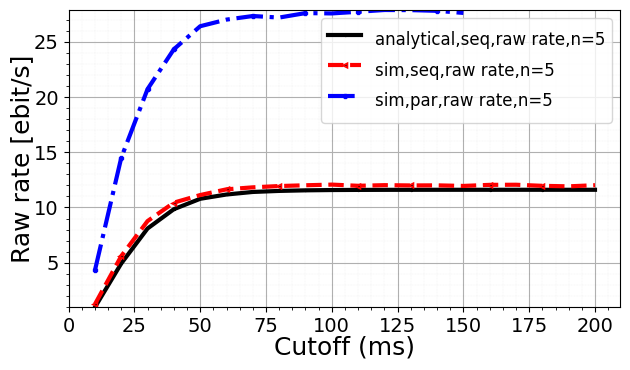

In [38]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

    # "parallel":"../results/equal_repeater_placement_experiment.csv",# with time step 5
        
    # "parallel":"../results/one_repeater_plaement_time_step_5_final.csv",# with time step 5 fixed expiring qubits
    "parallel":"../results/equal_distance_repeater_placement_exp_time_step_5.csv",# with time step 5 fixed end nodes memory time

    

    # "Seq3":"../results/equal_repeater_placement_experiment_time_stepn_one.csv",# with time step one


    # "Seq5":"../results/equal_repeater_placement_experiment_time_stepn_5.csv"# with time step 5


    # "sequential":"../results/one_repeater_plaement_time_step_5_final.csv"# with time step 5


        # "sequential":"../results/one_repeater_placement_time_step_5.csv",# with time step 5

            "sequential":"../results/equal_distance_repeater_placement_exp_time_step_5.csv"# with time step 5


    
    
}
system_keys = []
each_files_schemes = {
                     "parallel":["parallel"],
                     "sequential":["sequential"]}


each_scheme_ratio_e2e_rate ={}
L_values= []
system_keys = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[4])/1000
            except:
                cut_off = "False"
            e2e_rate = float(line[7])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[26])
            R = int(line[3])

#             if having_cut_off in ["True"]:
#                  analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            # 3 True True 400.0 0
            # print(R,cut_off)
            if  ( R in [1,3,5,8] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and avg_F !=0.0 and L in [400] and scheme in each_files_schemes[scheme_key]):

                if scheme =="parallel":
                    scheme ="sim,par"
                elif scheme =="sequential":
                    scheme = "sim,seq"
    #             print(line)
    #             scheme_title = scheme+", raw rate, L = "+str(L)
    #             scheme_skr_title = scheme+", skr, L = "+str(L)
                scheme_raw_title = scheme+",raw rate,n="+str(R)
                scheme_skr_title = scheme+",skr,n="+str(R)
                scheme_F_title = scheme+",F,n="+str(R)
                flag = False
                # print("passed")
                if scheme_raw_title not in system_keys:
                    system_keys.append(scheme_raw_title)
                if scheme_skr_title not in system_keys:
                    system_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_raw_title][cut_off].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_raw_title][cut_off] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_raw_title]={}
                        each_scheme_ratio_e2e_rate[scheme_raw_title][cut_off] = [e2e_rate]
                # e2e_rate_values.append(e2e_rate)
                        
                        
        
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]



                try:
                    each_scheme_ratio_e2e_rate[scheme_F_title][cut_off].append(avg_F)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_F_title][cut_off] = [avg_F]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_F_title]={}
                        each_scheme_ratio_e2e_rate[scheme_F_title][cut_off] = [avg_F]
                # e2e_rate_values.append(skr)
                

                if cut_off not in L_values:
                    L_values.append(cut_off)
         
rate_values = []
# print("system_keys",system_keys)
scheme_keys = [

                    # "analytical,seq,raw rate,n=1",
                    # "analytical,par,raw rate,n=1",
                     # "analytical,seq,skr,n=1",
                  #  "analytical,seq,F,n=1",
    
                    # "analytical,seq,raw rate,n=3",
                   # "analytical,seq,skr,n=3",
                   # "analytical,seq,F,n=3",
                   
                  "analytical,seq,raw rate,n=5",
                   # "analytical,seq,skr,n=5",
                   # "analytical,seq,F,n=5",
                   
                  # "analytical,seq,raw rate,n=8",
                  #  "analytical,seq,skr,n=8",
                  #  "analytical,seq,F,n=8",

                   
               
                   



                  # "sim,seq,raw rate,n=1",
                  #  "sim,seq,skr,n=1",
                  #  "sim,seq,F,n=1",

                    # "sim,seq,raw rate,n=3",
                   # "sim,seq,skr,n=3",
                   # "sim,seq,F,n=3",
                   
                  "sim,seq,raw rate,n=5",
                   # "sim,seq,skr,n=5",
                   # "sim,seq,F,n=5",
                   
                  # "sim,seq,raw rate,n=8",
                  #  "sim,seq,skr,n=8",
                  #  "sim,seq,F,n=8",



                # "sim,par,raw rate,n=1",
                   # "sim,par,skr,n=1",
                  #  "sim,par,F,n=1",
    
                 # "sim,par,raw rate,n=3",
                   # "sim,par,skr,n=3",
                   # "sim,par,F,n=3",
                   
                  "sim,par,raw rate,n=5",
                   # "sim,par,skr,n=5",
                   # "sim,par,F,n=5",
                   
                  # "sim,par,raw rate,n=8",
                  #  "sim,par,skr,n=8",
                  #  "sim,par,F,n=8"
    
                  ]
# print("scheme_keys ",scheme_keys)
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        avg_value = sum(values)/len(values)
        # print("for scheme %s point %s we have %s values "%(scheme,point,len(values)))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)

print("*************** \n \n")
selected_values = []

for scheme,point_vlaues in avg_each_scheme_ratio_e2e_rate.items():
    # print("scheme is ",scheme)
    if scheme in scheme_keys:
        for point,value in point_vlaues.items():
            selected_values.append(value)
        

L_values.sort()
# print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(selected_values),max(selected_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
# print("scheme_keys",scheme_keys)
# print("L_values ",L_values)
# print("avg_each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
ploting_simple_y_as_x("Cutoff (ms)","Raw rate [ebit/s]",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max(selected_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,True,1,12,
              "plots/repeater_chains_cutoff_rate.pdf",True,2,6.4,3.8,False)



In [ ]:
we have one expired qubit. Lets move the time to the point the expiration message arrives at sender  1825195 1825395 1825395
we have one expired qubit. Lets move the time to the point the expiration message arrives at sender  204500 204700 204700
F = 0.613005
raw_rate = 1.83125 for 150
SKR is 0.06806223

analytical,seq,raw rate,n=3 point 150.0 1.6519930671093899
analytical,seq,F,n=3 point 150.0 0.5350374529022418
analytical,seq,skr,n=3 point 150.0 0.05769747652734004
0.00585644
analytical,seq,raw rate,n=3 point 150.0 1.6519930671093899
analytical,seq,F,n=3 point 150.0 0.6095738302575425
analytical,seq,skr,n=3 point 150.0 0.05769747652734004
                                   0.05769748


In [ ]:
Le2e = 250 # e2e distance [km]
n = 3 # number of segments (i.e., no. of repeaters -1 )
Ls = [Le2e/n]*n
print(Ls)

In [ ]:
each_scheme_ratio_e2e_rate  ={}
L_values = []
for j in range(1000):
    for i in range(1000):
        if i not in L_values:
            L_values.append(i)
        if i in range(200,350):
            value = random.randint(400,500)
        elif i in range(350,450):
            value = random.randint(500,700)
        elif i in range(450,500):
            value = random.randint(700,900)
        elif i in range(500,550):
            value = random.randint(900,1000)
        else:
            value = random.randint(70,100)
        try:
            each_scheme_ratio_e2e_rate["Without AQM"][i].append(value)
        except:
            try:
                each_scheme_ratio_e2e_rate["Without AQM"][i] = [value]
            except:
                each_scheme_ratio_e2e_rate["Without AQM"]={}
                each_scheme_ratio_e2e_rate["Without AQM"][i] = [value]
    
        if i in range(200,300):
            value = random.randint(400,410)
        elif i in range(300,400):
            value = random.randint(410,440)
        elif i in range(400,470):
            value = random.randint(440,500)
        elif i in range(470,500):
            value = random.randint(500,550)
        elif i in range(500,520):
            value = random.randint(550,600)
        elif i in range(520,530):
            value = random.randint(600,650)
        elif i in range(530,550):
            value = random.randint(650,700)
        else:
            value = random.randint(70,100)

        
            
        try:
            each_scheme_ratio_e2e_rate["With AQM"][i].append(value)
        except:
            try:
                each_scheme_ratio_e2e_rate["With AQM"][i] = [value]
            except:
                each_scheme_ratio_e2e_rate["With AQM"]={}
                each_scheme_ratio_e2e_rate["With AQM"][i] = [value]

rate_values = []
avg_each_scheme_ratio_e2e_rate  ={}
for scheme,point_values in each_scheme_ratio_e2e_rate.items():    
    for point,values in point_values.items():
        avg_value = sum(values)/len(values)
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)

# ["with AQM, with congestion con.",
#                "wo AQM, wo congestion con."]
keys =["With AQM","Without AQM"]
ploting_simple_y_as_x("Time","Queeu size",
                14, 16, 14,
              14, 0, 0,
              0,0,max(rate_values),
              keys
              ,
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,False,1,17,
              "plots/QNUM.pdf",True,2,6.4,3.8,False)

In [ ]:
each_scheme_ratio_e2e_rate  ={}
L_values = []
for j in range(1000):
    for i in range(1000):
        if i not in L_values:
            L_values.append(i)
        if i in range(200,350):
            value = random.randint(400,500)
        elif i in range(350,450):
            value = random.randint(500,700)
        elif i in range(450,500):
            value = random.randint(700,900)
        elif i in range(500,550):
            value = random.randint(900,1000)
        else:
            value = random.randint(70,100)
        try:
            each_scheme_ratio_e2e_rate["Without AQM"][i].append(value)
        except:
            try:
                each_scheme_ratio_e2e_rate["Without AQM"][i] = [value]
            except:
                each_scheme_ratio_e2e_rate["Without AQM"]={}
                each_scheme_ratio_e2e_rate["Without AQM"][i] = [value]
    
        if i in range(200,300):
            value = random.randint(400,410)
        elif i in range(300,400):
            value = random.randint(410,440)
        elif i in range(400,470):
            value = random.randint(440,500)
        elif i in range(470,500):
            value = random.randint(500,550)
        elif i in range(500,520):
            value = random.randint(550,600)
        elif i in range(520,530):
            value = random.randint(600,650)
        elif i in range(530,550):
            value = random.randint(650,700)
        else:
            value = random.randint(70,100)

        
            
        try:
            each_scheme_ratio_e2e_rate["With AQM"][i].append(value)
        except:
            try:
                each_scheme_ratio_e2e_rate["With AQM"][i] = [value]
            except:
                each_scheme_ratio_e2e_rate["With AQM"]={}
                each_scheme_ratio_e2e_rate["With AQM"][i] = [value]

rate_values = []
avg_each_scheme_ratio_e2e_rate  ={}
for scheme,point_values in each_scheme_ratio_e2e_rate.items():    
    for point,values in point_values.items():
        avg_value = sum(values)/len(values)
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
ploting_simple_y_as_x("Time","Avg request service time",
                18, 18, 14,
              14, 0, 0,
              0,0,max(rate_values),
              
              ["Without AQM","With AQM"],
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,False,1,12,
              "plots/QNUM.pdf",True,2,6.4,3.8,False)

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

#     "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cut_off.csv",
#         "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cutoffv1.csv",
    "Seq5":"../results/repeater_chain_results_with_cut_off.csv"



    


    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

def analytical_avg_duration_calculation(length):
    p = 10**(-0.2*length/10)
    N = 1/p
    link_duration = (length/2e5*1000)
    return N*2*link_duration
def analytical_avg_duration_calculation_with_cutoff(length,cutoff,avg_duration):
    tau = ((length)/2e5*1000)
    m = int((cut_off)/(2*tau))
    p =10**(-0.2*length/10)
    q = 1-p
    Q2m = q**m
    P2m = 1-Q2m
    def Nm(p):
        return (1-(1+m*p)*q**m)/p
    flag = True
    try:
        T_m = (2*tau)/(p*P2m)+((1/P2m-1)*m+(Nm(p))/P2m)*2*tau
        flag = True
        print("p %s q %s m %s (%s/%s) Q2m %s P2m %s "%(p,q,m,cut_off,2*tau,Q2m,P2m))
        T_right_segment = Nm(p)/P2m
    except:
        T_m=0
        flag = False
    if flag:
        print("for length %s 2*tau %s T_right_segment %s cutoff %s p %s N %s tau %s m %s q %s avg_T %s avg_duration %s"%(length,
                                                                                                  2*tau,T_right_segment,
                                                                                                  cutoff,
                                                                                                  p,1/p,
                                                                                                  tau,m,q,
                                                                                                  T_m,
                                                                                                  avg_duration))

    return T_m,m,Nm(p),2*tau,flag

each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
system_keys = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            #print(line)
            invalid_line = False
            try:
                avg_duration = float(line[19])/1000
            except:
                invalid_line = True
            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
#             scheme_title = scheme+", raw rate, L = "+str(L)
#             scheme_skr_title = scheme+", skr, L = "+str(L)
            scheme_title = "system,par,raw rate, L = "+str(L)
            scheme_skr_title = "system,par, skr, L = "+str(L)
            flag = False
#             if having_cut_off in ["True"]:
#                  analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            
            if  ( R in [1] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and  1<=cut_off<=20 and L  in [150,50,10] and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                
                
                if scheme_title not in system_keys:
                    system_keys.append(scheme_title)
                if scheme_skr_title not in system_keys:
                    system_keys.append(scheme_skr_title)
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [e2e_rate]
                e2e_rate_values.append(e2e_rate)
                        
                        
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                e2e_rate_values.append(skr)
                
                
#                     avg_T_values.append(avg_T)
                if cut_off not in L_values:
                    L_values.append(cut_off)
         
rate_values = []
print("system_keys ",system_keys)
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
# print("schemes ",scheme_keys)
scheme_keys  = [
    
#     'seq, raw rate,L=150', 
#     'seq, raw rate w cutoff,L=150',
#     'seq skr w cutoff,L=150',
    'seq, raw rate w cutoff,L=50',
    'seq skr w cutoff,L=50',
#     'seq, raw rate w cutoff,L=10',
#     'seq skr w cutoff,L=10',
#  'system,raw rate, L = 50.0',
#     'system, skr, L = 50.0',
#     'system,raw rate, L = 10.0',
#     'system, skr, L = 10.0',
#     'system,raw rate, L = 100.0',
#     'system, skr, L = 100.0', 
#     'system,par,raw rate, L = 150.0', 
#     'system,par, skr, L = 150.0',
    'system,par,raw rate, L = 50.0', 
    'system,par, skr, L = 50.0',
    'system,par,raw rate, L = 100.0', 
    'system,par, skr, L = 100.0',
#     'system,par,raw rate, L = 10.0', 
#     'system,par, skr, L = 10.0',
#     'system,raw rate, L = 200.0', 'system, skr, L = 200.0', 'system,raw rate, L = 300.0', 'system, skr, L = 300.0', 'system,raw rate, L = 400.0', 'system, skr, L = 400.0', 'system,raw rate, L = 500.0', 'system, skr, L = 500.0', 'system,raw rate, L = 600.0', 'system, skr, L = 600.0'
    
             ]
print("*************** \n \n")
print("avg_each_scheme_ratio_e2e_rate",avg_each_scheme_ratio_e2e_rate)
selected_values = []

for scheme,point_vlaues in avg_each_scheme_ratio_e2e_rate.items():
    #if scheme in scheme_keys:
        for point,value in point_vlaues.items():
            selected_values.append(value)
        

L_values.sort()
print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(selected_values),max(selected_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
print("avg_each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
ploting_simple_y_as_x("cut_off (ms)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max(selected_values)+100,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,1,12,
              "plots/repeater_chains_sequential_cutoff_rate.pdf",True,2,9.4,3.8,True)



In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

#     "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cut_off.csv",
#         "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cutoffv1.csv",
    "Seq5":"../results/repeater_chain_sequential_scheme.csv"



    


    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

def analytical_avg_duration_calculation(length):
    p = 10**(-0.2*length/10)
    N = 1/p
    link_duration = (length/2e5*1000)
    return N*2*link_duration
def analytical_avg_duration_calculation_with_cutoff(length,cutoff,avg_duration):
    tau = ((length)/2e5*1000)
    m = int((cut_off)/(2*tau))
    p =10**(-0.2*length/10)
    q = 1-p
    Q2m = q**m
    P2m = 1-Q2m
    def Nm(p):
        return (1-(1+m*p)*q**m)/p
    flag = True
    try:
        T_m = (2*tau)/(p*P2m)+((1/P2m-1)*m+(Nm(p))/P2m)*2*tau
        flag = True
        print("p %s q %s m %s (%s/%s) Q2m %s P2m %s "%(p,q,m,cut_off,2*tau,Q2m,P2m))
        T_right_segment = Nm(p)/P2m
    except:
        T_m=0
        flag = False
    if flag:
        print("for length %s 2*tau %s T_right_segment %s cutoff %s p %s N %s tau %s m %s q %s avg_T %s avg_duration %s"%(length,
                                                                                                  2*tau,T_right_segment,
                                                                                                  cutoff,
                                                                                                  p,1/p,
                                                                                                  tau,m,q,
                                                                                                  T_m,
                                                                                                  avg_duration))

    return T_m,m,Nm(p),2*tau,flag

each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
system_keys = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            #print(line)
            invalid_line = False
            try:
                avg_duration = float(line[19])/1000
            except:
                invalid_line = True
            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+", raw rate, L = "+str(L)
            scheme_skr_title = scheme+", skr, L = "+str(L)
            scheme_title = "system,raw rate, L = "+str(L)
            scheme_skr_title = "system, skr, L = "+str(L)
            flag = False
#             if having_cut_off in ["True"]:
#                  analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            
            if  ( R in [1] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and  cut_off<=5 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                
                
                if scheme_title not in system_keys:
                    system_keys.append(scheme_title)
                if scheme_skr_title not in system_keys:
                    system_keys.append(scheme_skr_title)
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [e2e_rate]
                e2e_rate_values.append(e2e_rate)
                        
                        
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                e2e_rate_values.append(skr)
                
                
#                     avg_T_values.append(avg_T)
                if cut_off not in L_values:
                    L_values.append(cut_off)
         
rate_values = []
print("system_keys ",system_keys)
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
# print("schemes ",scheme_keys)
scheme_keys  = [
    
#     'seq, raw rate,L=150', 
    'seq, raw rate w cutoff,L=150',
#     'seq, skr,L=150',
    'seq skr w cutoff,L=150'
    ,
#  'system,raw rate, L = 50.0',
#     'system, skr, L = 50.0',
#     'system,raw rate, L = 10.0',
#     'system, skr, L = 10.0',
#     'system,raw rate, L = 100.0',
#     'system, skr, L = 100.0', 
    'system,raw rate, L = 150.0', 'system, skr, L = 150.0',
#     'system,raw rate, L = 200.0', 'system, skr, L = 200.0', 'system,raw rate, L = 300.0', 'system, skr, L = 300.0', 'system,raw rate, L = 400.0', 'system, skr, L = 400.0', 'system,raw rate, L = 500.0', 'system, skr, L = 500.0', 'system,raw rate, L = 600.0', 'system, skr, L = 600.0'
    
             ]

selected_values = []

for scheme,point_vlaues in avg_each_scheme_ratio_e2e_rate.items():
    if scheme in scheme_keys:
        for point,value in point_vlaues.items():
            selected_values.append(value)
        

L_values.sort()
print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(selected_values),max(selected_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("cut_off (ms)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max(selected_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,1,12,
              "plots/repeater_chains_sequential_cutoff_rate.pdf",True,2,9.4,3.8,True)



In [ ]:
selected_values = [55]
dictionary_keys_in_order = ["Shahrooz", "Kenneth"]
each_scheme_each_step_value  = {"Shahrooz":{0:10,1:11,2:13,3:14,4:15,5:16,10:20,20:45,
                                              30:55},
                                  "Kenneth":{0:11,1:12,2:14,3:15,4:16,5:17,10:25,20:45,
                                              30:55}}
x_axis_points = [0,1,2,3,4,5,10,20,30]
having_mark_on_linkes_flag =True
given_marker_size =4
x_min_value = 0
log_scale =True
legend_flag =True
legend_font_size = 12
legend_num_column = 1
legends_on_the_right_flag = True
y_axis_provided_min_value = 0
y_axis_provided_max_value = 60
image_width = 9.4
image_lenght = 3.8
x_axis_tick_font_size = 12
y_axis_tick_font_size = 12
x_axis_label = "cut_off"
x_axis_font_size = 12
x_axis_pad = 0
y_axis_label = "ebit/s"
y_axis_font_size = 12
y_axis_pad = 0

plot_name =    "plots/repeater_chains_ploting_testing.pdf"
colors = ['BLACK', 'RED', 'BLUE','GREEN','MAROON','AQUA','OLIVE','LIME','TEAL']
style=[ 'solid', 'dashed', 'dashdot', 'dotted',":",'solid', 'dashed', 'dashdot']

global style
#matplotlib.rcParams['text.usetex'] = True
global markers

global descriptions

label_size = 40
#matplotlib.rcParams['text.usetex'] = True
csfont = {'fontname':'Times New Roman'}


ax = plt.subplot(111)





ax = plt.subplot(111)
axins0 = inset_axes(ax, width="45%", height="40%", loc='lower right',borderpad=2)
axins0.set_xlim((0, 4))
axins0.set_ylim((10, 17))

my_dic = {}


my_class_labels = []


#     x = np.arange(len(topologies))
x = np.arange(max(x_axis_points))
x = []
for point_x_axis in x_axis_points:
    x.append((point_x_axis))
x.sort()
sizes = []

index = 0
color_index =0
for scheme_key in dictionary_keys_in_order:
    label_of_result = scheme_key
    y_axis_values = []
    import math
    from math import log
    x_values_for_this_scheme = []
    for point in x_axis_points:
        try:
            value  = each_scheme_each_step_value[scheme_key][point]
            y_axis_values.append(value)
            x_values_for_this_scheme.append(point)
        except:
            pass
    sizes.append(str(scheme_key))
    
    ax.plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
         linestyle=style[index],marker=markers[index],markevery=(0.0,0.1),linewidth=3.0,
         markersize=given_marker_size,markerfacecolor='black',markeredgewidth='2', 
         markeredgecolor=colors[color_index])

    axins0.plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
         linestyle=style[index],marker=markers[index],markevery=(0.0,0.1),linewidth=3.0,
         markersize=given_marker_size,markerfacecolor='black',markeredgewidth='2', 
         markeredgecolor=colors[color_index])        


    index = index +1
    color_index+=1
    if color_index >=len(colors):
        color_index = 1
    if index >= len(style):
        index = 2





my_class_labels = sizes

    

if legend_flag:
    ax.legend([label for label in my_class_labels ],fontsize=legend_font_size, ncol=legend_num_column,handleheight=2.4, labelspacing=0.02)
if legends_on_the_right_flag:
    
    ax.legend([label for label in my_class_labels ],fontsize=legend_font_size,loc='center left', bbox_to_anchor=(1, 0.5))

    
 
mark_inset(ax, axins0, loc1=2, loc2=4, fc="none", ec='0.5')

# axins0.set(yticklabels=[])
# axins0.set(xticklabels=[])
ax.legend()
    
plt.show()
    
 
# ploting_simple_y_as_x("cut_off (ms)","ebit/s",
#                 18, 18, 14,
#               14, 0, 0,
#               0,0,max(selected_values),
              
#               list(scheme_keys),
#               avg_each_scheme_ratio_e2e_rate,
#               L_values,L_values,
#               True,True,True,1,12,
#               "plots/repeater_chains_ploting_testing.pdf",True,2,9.4,3.8,True)


In [ ]:
selected_values = [55]
dictionary_keys_in_order = ["Shahrooz", "Kenneth"]
each_scheme_each_step_value  = {"Shahrooz":{0:10,1:11,2:13,3:14,4:15,5:16,10:20,20:45,
                                              30:55},
                                  "Kenneth":{0:11,1:12,2:14,3:15,4:16,5:17,10:25,20:45,
                                              30:55}}
x_axis_points = [0,1,2,3,4,5,10,20,30]
having_mark_on_linkes_flag =True
given_marker_size =4
x_min_value = 0
log_scale =True
legend_flag =True
legend_font_size = 12
legend_num_column = 1
legends_on_the_right_flag = True
y_axis_provided_min_value = 0
y_axis_provided_max_value = 60
image_width = 9.4
image_lenght = 3.8
x_axis_tick_font_size = 12
y_axis_tick_font_size = 12
x_axis_label = "cut_off"
x_axis_font_size = 12
x_axis_pad = 0
y_axis_label = "ebit/s"
y_axis_font_size = 12
y_axis_pad = 0

plot_name =    "plots/repeater_chains_ploting_testing.pdf"
colors = ['BLACK', 'RED', 'BLUE','GREEN','MAROON','AQUA','OLIVE','LIME','TEAL']
style=[ 'solid', 'dashed', 'dashdot', 'dotted',":",'solid', 'dashed', 'dashdot']
fig = plt.figure()

fig.set_size_inches(image_width, image_lenght, forward=True)# default 
#     fig.set_size_inches(14, 8)
#     fig.set_size_inches(8, 6)
global style
#matplotlib.rcParams['text.usetex'] = True
global markers

global descriptions

label_size = 40
#matplotlib.rcParams['text.usetex'] = True
csfont = {'fontname':'Times New Roman'}
#write your code related to basemap here
#plt.title('title',**csfont)
plt.rcParams['xtick.labelsize'] = x_axis_tick_font_size 
#matplotlib.rcParams['text.usetex'] = True
plt.rcParams['ytick.labelsize']= y_axis_tick_font_size
#matplotlib.rcParams['text.usetex'] = True
plt.xlabel(x_axis_label, fontsize=x_axis_font_size,labelpad=x_axis_pad)
#matplotlib.rcParams['text.usetex'] = True
plt.ylabel(y_axis_label,fontsize=y_axis_font_size,labelpad=y_axis_pad)

ax = plt.subplot(111)

plt.grid(True)
plt.tight_layout()






my_dic = {}


my_class_labels = []


#     x = np.arange(len(topologies))
x = np.arange(max(x_axis_points))
x = []
for point_x_axis in x_axis_points:
    x.append((point_x_axis))
x.sort()
sizes = []

index = 0
color_index =0
for scheme_key in dictionary_keys_in_order:
    label_of_result = scheme_key
    y_axis_values = []
    import math
    from math import log
    x_values_for_this_scheme = []
    for point in x_axis_points:
        try:
            value  = each_scheme_each_step_value[scheme_key][point]
            y_axis_values.append(value)
            x_values_for_this_scheme.append(point)
        except:
            pass
    sizes.append(str(scheme_key))
    if having_mark_on_linkes_flag:
        plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
             linestyle=style[index],marker=markers[index],markevery=(0.0,0.1),linewidth=3.0,
             markersize=given_marker_size,markerfacecolor='black',markeredgewidth='2', 
             markeredgecolor=colors[color_index])
    else:
        plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
             linestyle=style[index],markevery=(0.0,0.1),linewidth=3.0)

    index = index +1
    color_index+=1
    if color_index >=len(colors):
        color_index = 1
    if index >= len(style):
        index = 2





my_class_labels = sizes

plt.grid(True)

plt.xlim(xmin=x_min_value)

plt.grid(True)

plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

plt.tight_layout()
if log_scale:
    plt.yscale('log')
    

if legend_flag:
    ax.legend([label for label in my_class_labels ],fontsize=legend_font_size, ncol=legend_num_column,handleheight=2.4, labelspacing=0.02)
if legends_on_the_right_flag:
    ax = plt.subplot(111)
    ax.legend([label for label in my_class_labels ],fontsize=legend_font_size,loc='center left', bbox_to_anchor=(1, 0.5))

    
    
plt.ylim(y_axis_provided_min_value, y_axis_provided_max_value)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

#     plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid( which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

plt.savefig(plot_name)
plt.show()
    
    
    
 
# ploting_simple_y_as_x("cut_off (ms)","ebit/s",
#                 18, 18, 14,
#               14, 0, 0,
#               0,0,max(selected_values),
              
#               list(scheme_keys),
#               avg_each_scheme_ratio_e2e_rate,
#               L_values,L_values,
#               True,True,True,1,12,
#               "plots/repeater_chains_ploting_testing.pdf",True,2,9.4,3.8,True)


In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

#     "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cut_off.csv",
#         "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cutoffv1.csv",
    "Seq5":"../results/repeater_chain_sequential_scheme_changing_position.csv"



    


    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
avg_each_scheme_ratio_e2e_rate = {}

each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
system_keys = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            #print(line)
            invalid_line = False
            try:
                avg_duration = float(line[19])/1000
            except:
                invalid_line = True
            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
#             scheme_title = scheme+", raw rate, $\tau_0$ = "+str(cut_off)
#             scheme_skr_title = scheme+", skr, $\tau_0$ = "+str(cut_off)
            scheme_title = "system,raw rate, $\tau_0$ = "+str(cut_off)
            scheme_skr_title = "system, skr, $\tau_0$ = "+str(cut_off)
            flag = False
#             if having_cut_off in ["True"]:
#                  analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            
            if  ( R in [1] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and gen_delay in ["True"]
                 ):
                
                
                if scheme_title not in system_keys:
                    system_keys.append(scheme_title)
                if scheme_skr_title not in system_keys:
                    system_keys.append(scheme_skr_title)
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][L].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                e2e_rate_values.append(e2e_rate)
                        
                        
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                e2e_rate_values.append(skr)
                
                
#                     avg_T_values.append(avg_T)
                if L not in L_values:
                    L_values.append(L)
         
rate_values = []
print("system_keys ",system_keys)
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
# print("schemes ",scheme_keys)
scheme_keys = [
    'seq, raw rate w cutoff,$\tau_0$=1.0',
    'seq skr w cutoff,$\tau_0$=1.0',
    'seq, raw rate w cutoff,$\tau_0$=2.0',
    'seq skr w cutoff,$\tau_0$=2.0',
        'seq, raw rate w cutoff,$\tau_0$=3.0',
    'seq skr w cutoff,$\tau_0$=3.0',
    'seq, raw rate w cutoff,$\tau_0$=4.0',
    'seq skr w cutoff,$\tau_0$=4.0',
#     'seq, raw rate w cutoff,$\tau_0$=8.0',
#     'seq skr w cutoff,$\tau_0$=8.0',
#     'seq, raw rate w cutoff,$\tau_0$=10.0',
#     'seq skr w cutoff,$\tau_0$=10.0',
#     'seq, raw rate w cutoff,$\tau_0$=20.0',
#     'seq skr w cutoff,$\tau_0$=20.0',
#     'seq, raw rate w cutoff,$\tau_0$=40.0',
#     'seq skr w cutoff,$\tau_0$=40.0',
#     'seq, raw rate w cutoff,$\tau_0$=80.0',
#     'seq skr w cutoff,$\tau_0$=80.0',
#     'seq, raw rate w cutoff,$\tau_0$=100.0', 
#     'seq skr w cutoff,$\tau_0$=100.0',
#     'seq, raw rate w cutoff,$\tau_0$=200.0',
#     'seq skr w cutoff,$\tau_0$=200.0',
#     'seq, raw rate w cutoff,$\tau_0$=400.0',
#     'seq skr w cutoff,$\tau_0$=400.0',
    
#               'system,raw rate, $\tau_0$ = 0.01',
#     'system, skr, $\tau_0$ = 0.01',
#     'system,raw rate, $\tau_0$ = 0.02',
#     'system, skr, $\tau_0$ = 0.02',
#     'system,raw rate, $\tau_0$ = 0.04',
#     'system, skr, $\tau_0$ = 0.04',
#     'system,raw rate, $\tau_0$ = 0.1',
#     'system, skr, $\tau_0$ = 0.1',
#     'system,raw rate, $\tau_0$ = 0.2',
#     'system, skr, $\tau_0$ = 0.2',
#     'system,raw rate, $\tau_0$ = 0.4',
#     'system, skr, $\tau_0$ = 0.4', 
#     'system,raw rate, $\tau_0$ = 0.8',
#     'system, skr, $\tau_0$ = 0.8',
    'system,raw rate, $\tau_0$ = 1.0',
    'system, skr, $\tau_0$ = 1.0', 
    'system,raw rate, $\tau_0$ = 2.0',
    'system, skr, $\tau_0$ = 2.0', 
    'system,raw rate, $\tau_0$ = 4.0',
    'system, skr, $\tau_0$ = 4.0',
    'system,raw rate, $\tau_0$ = 6.0',
    'system, skr, $\tau_0$ = 6.0',
#     'system,raw rate, $\tau_0$ = 8.0',
#     'system, skr, $\tau_0$ = 8.0',
#     'system,raw rate, $\tau_0$ = 10.0',
#     'system, skr, $\tau_0$ = 10.0',
#     'system,raw rate, $\tau_0$ = 20.0',
#     'system, skr, $\tau_0$ = 20.0',
#     'system,raw rate, $\tau_0$ = 40.0',
#     'system, skr, $\tau_0$ = 40.0',
#     'system,raw rate, $\tau_0$ = 80.0',
#     'system, skr, $\tau_0$ = 80.0',
#     'system,raw rate, $\tau_0$ = 100.0',
#     'system, skr, $\tau_0$ = 100.0',
#     'system,raw rate, $\tau_0$ = 200.0',
#     'system, skr, $\tau_0$ = 200.0',
#     'system,raw rate, $\tau_0$ = 400.0', 
#     'system, skr, $\tau_0$ = 400.0'
    
             ]

selected_values = []

for scheme,point_vlaues in avg_each_scheme_ratio_e2e_rate.items():
    if scheme in scheme_keys:
        for point,value in point_vlaues.items():
            selected_values.append(value)
        

L_values.sort()
print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(selected_values),max(selected_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("Left link length (km)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              min(selected_values)-1,min_x,max(selected_values)+100,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,2,12,
              "plots/repeater_chains_sequential_L_position_rate.pdf",True,2,9.4,3.8,True)



In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

#     "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cut_off.csv",
#         "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cutoffv1.csv",
    "Seq5":"../results/repeater_chain_sequential_scheme.csv"



    


    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}


each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
system_keys = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            #print(line)
            invalid_line = False
            try:
                avg_duration = float(line[19])/1000
            except:
                invalid_line = True
            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
#             scheme_title = scheme+", raw rate, $\tau_0$ = "+str(cut_off)
#             scheme_skr_title = scheme+", skr, $\tau_0$ = "+str(cut_off)
            scheme_title = "system,raw rate, $\tau_0$ = "+str(cut_off)
            scheme_skr_title = "system, skr, $\tau_0$ = "+str(cut_off)
            flag = False
#             if having_cut_off in ["True"]:
#                  analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            
            if  ( R in [1] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and gen_delay in ["True"]
                 ):
                
                
                if scheme_title not in system_keys:
                    system_keys.append(scheme_title)
                if scheme_skr_title not in system_keys:
                    system_keys.append(scheme_skr_title)
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][L].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                e2e_rate_values.append(e2e_rate)
                        
                        
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                e2e_rate_values.append(skr)
                
                
#                     avg_T_values.append(avg_T)
                if L not in L_values:
                    L_values.append(L)
         
rate_values = []
print("system_keys ",system_keys)
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
# print("schemes ",scheme_keys)
scheme_keys = [
#     'seq, raw rate w cutoff,$\tau_0$=4.0',
#     'seq skr w cutoff,$\tau_0$=4.0',
#     'seq, raw rate w cutoff,$\tau_0$=6.0',
#     'seq skr w cutoff,$\tau_0$=6.0',
#     'seq, raw rate w cutoff,$\tau_0$=8.0',
#     'seq skr w cutoff,$\tau_0$=8.0',
#     'seq, raw rate w cutoff,$\tau_0$=10.0',
#     'seq skr w cutoff,$\tau_0$=10.0',
#     'seq, raw rate w cutoff,$\tau_0$=20.0',
#     'seq skr w cutoff,$\tau_0$=20.0',
#     'seq, raw rate w cutoff,$\tau_0$=40.0',
#     'seq skr w cutoff,$\tau_0$=40.0',
#     'seq, raw rate w cutoff,$\tau_0$=80.0',
#     'seq skr w cutoff,$\tau_0$=80.0',
#     'seq, raw rate w cutoff,$\tau_0$=100.0', 
#     'seq skr w cutoff,$\tau_0$=100.0',
#     'seq, raw rate w cutoff,$\tau_0$=200.0',
#     'seq skr w cutoff,$\tau_0$=200.0',
#     'seq, raw rate w cutoff,$\tau_0$=400.0',
#     'seq skr w cutoff,$\tau_0$=400.0',
    
        'seq, raw rate w cutoff,$\tau_0$=1000.0',
    'seq skr w cutoff,$\tau_0$=1000.0',

        'seq, raw rate w cutoff,$\tau_0$=2000.0',
    'seq skr w cutoff,$\tau_0$=2000.0',

    
#               'system,raw rate, $\tau_0$ = 0.01',
#     'system, skr, $\tau_0$ = 0.01',
#     'system,raw rate, $\tau_0$ = 0.02',
#     'system, skr, $\tau_0$ = 0.02',
#     'system,raw rate, $\tau_0$ = 0.04',
#     'system, skr, $\tau_0$ = 0.04',
#     'system,raw rate, $\tau_0$ = 0.1',
#     'system, skr, $\tau_0$ = 0.1',
#     'system,raw rate, $\tau_0$ = 0.2',
#     'system, skr, $\tau_0$ = 0.2',
#     'system,raw rate, $\tau_0$ = 0.4',
#     'system, skr, $\tau_0$ = 0.4', 
#     'system,raw rate, $\tau_0$ = 0.8',
#     'system, skr, $\tau_0$ = 0.8',
#     'system,raw rate, $\tau_0$ = 1.0',
#     'system, skr, $\tau_0$ = 1.0', 
#     'system,raw rate, $\tau_0$ = 2.0',
#     'system, skr, $\tau_0$ = 2.0', 
#     'system,raw rate, $\tau_0$ = 4.0',
#     'system, skr, $\tau_0$ = 4.0',
#     'system,raw rate, $\tau_0$ = 6.0',
#     'system, skr, $\tau_0$ = 6.0',
#     'system,raw rate, $\tau_0$ = 8.0',
#     'system, skr, $\tau_0$ = 8.0',
#     'system,raw rate, $\tau_0$ = 10.0',
#     'system, skr, $\tau_0$ = 10.0',
#     'system,raw rate, $\tau_0$ = 20.0',
#     'system, skr, $\tau_0$ = 20.0',
#     'system,raw rate, $\tau_0$ = 40.0',
#     'system, skr, $\tau_0$ = 40.0',
#     'system,raw rate, $\tau_0$ = 80.0',
#     'system, skr, $\tau_0$ = 80.0',
#     'system,raw rate, $\tau_0$ = 100.0',
#     'system, skr, $\tau_0$ = 100.0',
#     'system,raw rate, $\tau_0$ = 200.0',
#     'system, skr, $\tau_0$ = 200.0',
#     'system,raw rate, $\tau_0$ = 400.0', 
#     'system, skr, $\tau_0$ = 400.0',
    'system,raw rate, $\tau_0$ = 1000.0',
    'system, skr, $\tau_0$ = 1000.0', 
    'system,raw rate, $\tau_0$ = 2000.0',
    'system, skr, $\tau_0$ = 2000.0'
    
    
             ]

selected_values = []

for scheme,point_vlaues in avg_each_scheme_ratio_e2e_rate.items():
    if scheme in scheme_keys:
        for point,value in point_vlaues.items():
            selected_values.append(value)
        

L_values.sort()
print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(selected_values),max(selected_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("L (km)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max(selected_values)+100,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,2,12,
              "plots/repeater_chains_sequential_L_rate.pdf",True,2,9.4,3.8,True)



In [ ]:
scheme_keys = []
avg_each_scheme_ratio_e2e_rate = {}
for cut_off in [0.01,0.02,0.04,0.1,0.2,0.4,0.8,1,2,4,6,8,10,20,40,80,100,200,400]:
    cut_off = cut_off/1000
    print("for cut off",cut_off)
    flag = True
    try:
        analytical_schemes,each_scheme_point_values,L0_list = get_analytical_results_with_cut_off(2,cut_off)
    except:
        flag = False
    if flag:
        indx = 0
        e2e_rate_values = []
        avg_T_values = []
        each_L_index = {}
        
        for L in L0_list:
            each_L_index[L] = indx
            indx+=1
        for scheme in analytical_schemes:
#             print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values.keys())
            for L in L0_list:
                #if L<500:
                #print(L)
                value = each_scheme_point_values[scheme][each_L_index[L]]
                if "T" in scheme:
                    value = value*1000
                #value = math.log(value)
        #             print("for scheme %s L %s value %s "%(scheme,L,value))
                new_scheme = scheme+",L0="+str(L)
                if new_scheme not in scheme_keys:
                    scheme_keys.append(new_scheme)
                try:
                    avg_each_scheme_ratio_e2e_rate[new_scheme][cut_off*1000] = value
                except:
                    avg_each_scheme_ratio_e2e_rate[new_scheme]={}
                    avg_each_scheme_ratio_e2e_rate[new_scheme][cut_off*1000] = value 

                avg_T_values.append(value)
        print("done")
    
# L0 100.0 2*tau 0.5 T_right_segment 7.23 cutoff 10.0 p 0.1 N 10.0 tau 0.25 m 20 q 0.9 avg_T 10.6 system_T 7.114

print("scheme_keys ",scheme_keys)

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
scheme_keys = []
each_scheme_ratio_e2e_rate = {}
avg_each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

#     "Seq4":"../results/repeater_chain_sequential_one_repeater_testingv2.csv",
#     "Seq3":"../results/repeater_chain_sequential_one_repeater_testingv3.csv",
#      "Seq5":"../results/repeater_chain_sequential_one_repeater_testingv4.csv",
    "Seq5":"../results/repeater_chain_sequential_one_repeater_testingv5.csv"


    


    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

def analytical_avg_duration_calculation(length):
    p = 10**(-0.2*length/10)
    N = 1/p
    link_duration = (length/2e5*1000)
    return N*2*link_duration


def compute_rate_with_cutoff(length,cut_off):
    tau1 = (length/2e5*1000)
    tau2 = (length/2e5*1000)
    p1 =10**(-0.2*length/10)
    m = math.floor(cutoff/2*tau2)
    q = 1-p1
    Q2m = q**m
    P2m = 1-Q2m
    def Nm(p):
        return (1-(1+m*p)*q**m)/p1
    avg_T = (2*tau1/(p1*P2m))+(1/P2m-1)*m+Nm(p2)*2*tau2+tau1
    rate = 1/avg_T
    return rate
each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
        
            length =float(line[4])
            L = (float(line[14]))
            
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
#             print("L0 is %s sublink length is %s having_cut_off %s cut_off %s  "%(L,length,having_cut_off,cut_off))

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            avg_duration = float(line[19])/1000
#             if having_cut_off=="True":
#                 print("L %s avg_F %s e_x %s e_z %s"%(L,avg_F,im_e_x,im_e_z))
            

            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+", raw rate, cut_off = "+str(cut_off)
            scheme_skr_title = scheme+", skr, cut_ff = "+str(cut_off)
            scheme_title = "system, cut_off = "+str(cut_off)
            scheme_skr_title = "analytical, cut_ff = "+str(cut_off)
#             if having_cut_off=="True":
#                 print("R %s cut_off %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,cut_off,having_cut_off,exp_class_com,L))
            if  (R in [1] and having_cut_off in ["True","False"]  and 
                 exp_class_com in ["True"] and L <=500 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
#                     if scheme_T_title not in scheme_keys:
#                         scheme_keys.append(scheme_T_title)
#                     if scheme_F_title not in scheme_keys:
#                         scheme_keys.append(scheme_F_title)
#                 print("passed",having_cut_off,scheme_skr_title,scheme_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][L].append(avg_duration)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [avg_duration]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [avg_duration]
                analytical_avg_duration = analytical_avg_duration_calculation(L/2)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(analytical_avg_duration)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [analytical_avg_duration]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [analytical_avg_duration]


#                     new_scheme_title = "par,my code to generate skr using F and raw rate"
#                     if new_scheme_title not in scheme_keys:
#                         scheme_keys.append(new_scheme_title)
#                     avg_F_from_analytical = avg_each_scheme_ratio_e2e_rate["analytic, par, F"][L]
#                     e2e_rate_from_analytical = avg_each_scheme_ratio_e2e_rate["analytic, par, raw rate"][L]
# #                     skr = sekret_key(R,e2e_rate,avg_F)
#                     new_skr = sekret_key(R,e2e_rate_from_analytical,avg_F_from_analytical)
#                     print("L %s system avg F %s analytical avg F %s "%(round(L,4),avg_F,avg_F_from_analytical))   
#                     try:
#                         each_scheme_ratio_e2e_rate[new_scheme_title][L].append(new_skr)
#                     except:
#                         try:
#                             each_scheme_ratio_e2e_rate[new_scheme_title][L] = [new_skr]
#                         except:
#                             each_scheme_ratio_e2e_rate[new_scheme_title]={}
#                             each_scheme_ratio_e2e_rate[new_scheme_title][L] = [new_skr]

                e2e_rate_values.append(avg_duration)
                e2e_rate_values.append(analytical_avg_duration)
#                     avg_T_values.append(avg_T)
                if L not in L_values:
                    L_values.append(L)
         
rate_values = []
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
        print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
print("schemes ",scheme_keys)


L_values.sort()
print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(rate_values),max(rate_values)
# min_x,max_x = 0,1
# scheme_keys =["analytic, seq, T",
# #               "analytic, seq, raw rate min T",
#  "sequential, T"
#              ]


# scheme_keys= [
#               'parallel, raw rate',
#                 'analytic, par, raw rate',
#      'parallel, skr',
#                 'analytic, par, skr',
              
#               ]
# scheme_keys= [
#               'parallel-ASAP, raw rate', 
             
#                'analytic, par, raw rate',
#               ]
# print("each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
# scheme_keys = []
# L0_list = list(L0_list)
# for L in L0_list:
#     if L not in L_values and L <= max(L_values):
#         L_values.append(L)
# print("avg_each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate["analytic, par, raw rate"])
L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("L (km)","Time to generate fist successful \n link on first segment(ms)",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max_x,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,True,1,9,
              "plots/repeater_chains_first_segment_creation_duration.pdf",True,2,6.4,3.8)



In [ ]:
# number of expired qubits

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
scheme_keys = []
each_scheme_ratio_e2e_rate = {}
avg_each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

#     "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cut_off.csv",
#         "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cutoffv1.csv",
    "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cutoff_new.csv"



    


    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

def analytical_avg_duration_calculation(length):
    p = 10**(-0.2*length/10)
    N = 1/p
    link_duration = (length/2e5*1000)
    return N*2*link_duration
def analytical_avg_duration_calculation_with_cutoff(length,cutoff,avg_duration):
    tau = ((length)/2e5*1000)
    m = int((cut_off)/(2*tau))
    p =10**(-0.2*length/10)
    q = 1-p
    Q2m = q**m
    P2m = 1-Q2m
    def Nm(p):
        return (1-(1+m*p)*q**m)/p
    flag = True
    try:
        T_m = (2*tau)/(p*P2m)+((1/P2m-1)*m+(Nm(p))/P2m)*2*tau
        flag = True
    except:
        T_m=0
        flag = False
    print("for length %s 2*tau %s cutoff %s p %s N %s tau %s m %s q %s avg_T %s avg_duration %s"%(length,
                                                                                                  2*tau,
                                                                                                  cutoff,
                                                                                                  p,1/p,
                                                                                                  tau,m,q,
                                                                                                  T_m,
                                                                                                  avg_duration))

    return T_m,m,Nm(p),2*tau,flag

each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            expired_qubits = int(line[18])
            #print(line)
            invalid_line = False
            try:
                avg_duration = float(line[19])/1000
            except:
                invalid_line = True
            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+", raw rate, L = "+str(L)
            scheme_skr_title = scheme+", skr, L = "+str(L)
            scheme_title = "system, L = "+str(L)
            scheme_skr_title = "analytical, L = "+str(L)
            flag = False
            if having_cut_off in ["True"]:
                 analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            
            if  (flag and R in [1] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and L in [50,100,400,150] and  cut_off<400 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                
                
                
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off].append(expired_qubits)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [expired_qubits]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [expired_qubits]
                e2e_rate_values.append(expired_qubits)
                        
                        
#                 if scheme_skr_title not in scheme_keys:
#                     scheme_keys.append(scheme_skr_title)
#                 try:
#                     each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(analytical_avg_duration)
#                 except:
#                     try:
#                         each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [analytical_avg_duration]
#                     except:
#                         each_scheme_ratio_e2e_rate[scheme_skr_title]={}
#                         each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [analytical_avg_duration]
#                 e2e_rate_values.append(analytical_avg_duration)
                
                
#                     avg_T_values.append(avg_T)
                if cut_off not in L_values:
                    L_values.append(cut_off)
         
rate_values = []
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
print("schemes ",scheme_keys)


L_values.sort()
print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(rate_values),max(rate_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("cut_off (ms)","# of expired",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max_x+2,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,True,1,9,
              "plots/repeater_chains_first_segment_expired.pdf",True,2,6.4,3.8)



In [ ]:
L_values = []
scheme_keys = []
avg_each_scheme_ratio_e2e_rate = {}
each_scheme_ratio_e2e_rate  ={}
for L in [50,100,150,200]:
    scheme_skr_title = "Analytical, L="+str(L/2)
    if scheme_skr_title not in scheme_keys:
        scheme_keys.append(scheme_skr_title)
    for cut_off in [0.1,0.2,0.5,1,2,4,6,10,20,30,40,50]:
        length = L/2
        tau = ((length)/2e5*1000)
        m = int((cut_off)/(2*tau))
        p =10**(-0.2*length/10)
        q = 1-p
        Q2m = q**m
        P2m = 1-Q2m
        def Nm(p):
            return (1-(1+m*p)*q**m)/p
        flag = True
        try:
            T_m = (2*tau*(1-(1+m*p)*q**m))/(p*(1-(q**m)))
            flag = True
        except:
            flag = False
        print("for L %s cutoff %s m %s "%(length,cut_off,m))
        if flag:
            try:
                each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(2*tau)
            except:
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [2*tau]
                except:
                    each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [2*tau]
            e2e_rate_values.append(2*tau)
            if cut_off not in L_values:
                L_values.append(cut_off)
         
rate_values = []
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
print("schemes ",scheme_keys)


L_values.sort()
print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(rate_values),max(rate_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("cut_off (ms)","$2*tau (ms)$",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max_x+.1,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,True,1,9,
              "plots/repeater_chains_first_segment_creation_duration.pdf",True,2,6.4,3.8)


In [ ]:
avg_each_scheme_ratio_e2e_rate = {}
analytical_schemes,each_scheme_point_values,L0_list = get_analytical_results(2)
indx = 0
e2e_rate_values = []
avg_T_values = []
each_L_index = {}
for L in L0_list:
    each_L_index[L] = indx
    indx+=1
for scheme in analytical_schemes:
#     print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values[scheme])
    for L in L0_list:
        #if L<500:
        #print(L)
        value = each_scheme_point_values[scheme][each_L_index[L]]
        if "T" in scheme:
            value = value*1000
        #value = math.log(value)
#             print("for scheme %s L %s value %s "%(scheme,L,value))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][L] = value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][L] = value 
        
        avg_T_values.append(value)
    
print("analytical_schemes ",analytical_schemes)

In [ ]:
# avg_each_scheme_ratio_e2e_rate = {}
# for cut_off in [2,4,6,8,12,16,20,40,80,160,200,300,400,600,800,1000,2000,4000,8000]:#in milliseconds:
for cut_off in [0.1,1,5,20,100]:#in milliseconds:
# for cut_off in [0.1]:#in milliseconds:
    cut_off = cut_off/1000
    analytical_schemes,each_scheme_point_values,L0_list = get_analytical_results_with_cut_off(2,cut_off)
    indx = 0
    # e2e_rate_values = []
    # avg_T_values = []
    each_L_index = {}
    for L in L0_list:
        each_L_index[L] = indx
        indx+=1
    for scheme in analytical_schemes:
    #     print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values[scheme])
        for L in L0_list:
            #if L<500:
            value = each_scheme_point_values[scheme][each_L_index[L]]
            if pd.isna(value):
                value = 0
            
            try:
                avg_each_scheme_ratio_e2e_rate[scheme][L] = value
            except:
                avg_each_scheme_ratio_e2e_rate[scheme]={}
                avg_each_scheme_ratio_e2e_rate[scheme][L] = value 

            avg_T_values.append(value)
    
print("analytical_schemes ",analytical_schemes)

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
scheme_keys = []
each_scheme_result_file_path = {

    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_parallel.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv3.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv6.csv"
    
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv15.csv",
    # deterministic parallel links
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv5.csv",
    
#      "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testingv20.csv",
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing_v11.csv",
#       "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing_with_cut_offv11.csv",
    
    
#      "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testing_v11.csv"
#       "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testing_v11.csv",
    
    
    
#     "Seq5":"../results/repeater_chain_parallel_testing_with_cutoff_v12_testv3.csv"# tested and working fine
    
    
    
        # use both for parallel
#         "Seq5":"../results/repeater_chain_parallel_no_cut_off_testing.csv",# tested and working fine again
#         "Seq4":"../results/repeater_chain_parallel_with_cut_off_testing.csv"# 
    # for sequential
#             "Seq4":"../results/repeater_chain_testing_cut_offs.csv"# ,
#         "Seq4":"../results/repeater_chain_cut_off_values_expired_qubitsv3.csv"# ,
#             "Seq4":"../results/repeater_chain_sequential_with_cut_off.csv"# ,
#     "Seq4":"../results/repeater_chain_sequential_with_cut_offv2.csv",
    
#     "Seq4":"../results/repeater_chain_sequential_with_cut_offv3.csv"

    

   "Seq4":"../results/repeater_chain_sequential_one_repeater_testingv2.csv",
    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
        
            length =float(line[4])
            L = (float(line[14]))
            
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
#             print("L0 is %s sublink length is %s having_cut_off %s cut_off %s  "%(L,length,having_cut_off,cut_off))

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
#             if having_cut_off=="True":
#                 print("L %s avg_F %s e_x %s e_z %s"%(L,avg_F,im_e_x,im_e_z))
            

            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+", raw rate, cut_off = "+str(cut_off)
            scheme_skr_title = scheme+", skr, cut_ff = "+str(cut_off)
            scheme_title = "system, raw rate, cut_off = "+str(cut_off)
            scheme_skr_title = "system, skr, cut_ff = "+str(cut_off)
#             if having_cut_off=="True":
#                 print("R %s cut_off %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,cut_off,having_cut_off,exp_class_com,L))
            if  (R in [1] and having_cut_off in ["True","False"]  and 
                 exp_class_com in ["True"] and L <=400 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
#                     if scheme_T_title not in scheme_keys:
#                         scheme_keys.append(scheme_T_title)
#                     if scheme_F_title not in scheme_keys:
#                         scheme_keys.append(scheme_F_title)
#                 print("passed",having_cut_off,scheme_skr_title,scheme_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][L].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                skr = sekret_key(R,e2e_rate,avg_F)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]


#                     new_scheme_title = "par,my code to generate skr using F and raw rate"
#                     if new_scheme_title not in scheme_keys:
#                         scheme_keys.append(new_scheme_title)
#                     avg_F_from_analytical = avg_each_scheme_ratio_e2e_rate["analytic, par, F"][L]
#                     e2e_rate_from_analytical = avg_each_scheme_ratio_e2e_rate["analytic, par, raw rate"][L]
# #                     skr = sekret_key(R,e2e_rate,avg_F)
#                     new_skr = sekret_key(R,e2e_rate_from_analytical,avg_F_from_analytical)
#                     print("L %s system avg F %s analytical avg F %s "%(round(L,4),avg_F,avg_F_from_analytical))   
#                     try:
#                         each_scheme_ratio_e2e_rate[new_scheme_title][L].append(new_skr)
#                     except:
#                         try:
#                             each_scheme_ratio_e2e_rate[new_scheme_title][L] = [new_skr]
#                         except:
#                             each_scheme_ratio_e2e_rate[new_scheme_title]={}
#                             each_scheme_ratio_e2e_rate[new_scheme_title][L] = [new_skr]

                e2e_rate_values.append(e2e_rate)
                e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                if L not in L_values:
                    L_values.append(L)
         
rate_values = []
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']


# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
# for L in L0_list:
#     if L not in L_values:
#         L_values.append(L)

L_values.sort()
print("L_values ",L_values)
# L0_list = np.linspace(10,800,101)
# print("L0_list ",L0_list)
# for scheme in analytical_schemes:
#     scheme_keys.append(scheme)
print("schemes ",scheme_keys)
scheme_keys= [
#     'system, raw rate, cut_off = 10.0',
#     'system, skr, cut_ff = 10.0',
#     'system, raw rate, cut_off = 0.1',
#     'system, skr, cut_ff = 0.1',
#     'system, raw rate, cut_off = 1.0',
#     'system, skr, cut_ff = 1.0',
#         'system, raw rate, cut_off = 5.0',
#     'system, skr, cut_ff = 5.0',
#         'system, raw rate, cut_off = 20.0',
#     'system, skr, cut_ff = 20.0',
#     'system, raw rate, cut_off = 100.0',
#     'system, skr, cut_ff = 100.0',
#         'system, raw rate, cut_off = 1000.0',
#     'system, skr, cut_ff = 1000.0',
    'seq, raw rate', 
    'seq, skr',
#     'seq, raw rate w cutoff=10.0',
#     'seq skr w cutoff=10.0',
#     'seq, raw rate w cutoff=0.1',
#     'seq skr w cutoff=0.1',
#     'seq, raw rate w cutoff=1.0',
#     'seq skr w cutoff=1.0',
#         'seq, raw rate w cutoff=5.0',
#         'seq skr w cutoff=5.0',
#         'seq, raw rate w cutoff=20.0',
#         'seq skr w cutoff=20.0',
# 'sequential, raw rate, cut_off = False',
#     'sequential, skr, cut_ff = False',
#     'seq, raw rate w cutoff=100.0',
#     'seq skr w cutoff=100.0',
    
#     'seq, raw rate w cutoff=1000.0',
#     'seq skr w cutoff=1000.0',
    
#     'analytic, seq, raw rate', 
#     'analytic, seq, skr',
    
    
    'system, raw rate, cut_off = False',
    'system, skr, cut_ff = False'
    
]
min_x,max_x = 1e-4,1e5
min_x,max_x = min(rate_values),max(rate_values)
# min_x,max_x = 0,1
# scheme_keys =["analytic, seq, T",
# #               "analytic, seq, raw rate min T",
#  "sequential, T"
#              ]


# scheme_keys= [
#               'parallel, raw rate',
#                 'analytic, par, raw rate',
#      'parallel, skr',
#                 'analytic, par, skr',
              
#               ]
# scheme_keys= [
#               'parallel-ASAP, raw rate', 
             
#                'analytic, par, raw rate',
#               ]
# print("each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
# scheme_keys = []
# L0_list = list(L0_list)
# for L in L0_list:
#     if L not in L_values and L <= max(L_values):
#         L_values.append(L)
# print("avg_each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate["analytic, par, raw rate"])
L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("L (km)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max_x,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,1,9,
              "plots/repeater_chains_rate_system_analytical_with_cut_offs.pdf",True,2,6.4,3.8)



# plotting different Ls as cut-off

In [ ]:
list_of_links = [100,140,200,250,350,400]
list_of_links = [140,240,290]
list_of_links = [90,140,190]
# list_of_links = [96.9,199.60000000000002,302.3]
list_of_links = [96.9,199.60000000000002,302.3]
list_of_links = [199.60000000000002]
list_of_links = [302.3]

In [ ]:
avg_each_scheme_ratio_e2e_rate = {}
analytical_schemes,each_scheme_point_values,L0_list = get_analytical_results(2)
indx = 0
e2e_rate_values = []
avg_T_values = []
each_L_index = {}
scheme_keys = []
y_axis_values = []
for L in L0_list:
    each_L_index[L] = indx
    indx+=1
for scheme in analytical_schemes:
#     print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values[scheme])
    if "DT" not in scheme and "F" not in scheme and "seq," in scheme:
#     if "DT" not in scheme and "F" not in scheme:
        for L in L0_list:
#             print(L)
            if (L) in list_of_links:
                value = each_scheme_point_values[scheme][each_L_index[L]]
                scheme2 = scheme+", no cut-off, L="+str(int(L))
                if scheme2 not in scheme_keys:
                    scheme_keys.append(scheme2)
                print("for scheme %s L %s value %s "%(scheme2,L,value))
                try:
                    avg_each_scheme_ratio_e2e_rate[scheme2][0] = value
                except:
                    avg_each_scheme_ratio_e2e_rate[scheme2]={}
                    avg_each_scheme_ratio_e2e_rate[scheme2][0] = value 

                avg_T_values.append(value)
                y_axis_values.append(value)

      
# scheme_keys = [
#                   "analytic, seq, F",
#                   "analytic, par, F"]
# # print("avg_each_scheme_ratio_e2e_rate",avg_each_scheme_ratio_e2e_rate)
# # ploting_simple_y_as_x("L (km)","average F",
# #                 18, 18, 14,
# #               14, 0, 0,
# #               0,0,1.1,
              
# #               list(scheme_keys),
# #               avg_each_scheme_ratio_e2e_rate,
# #               L0_list,L0_list,
# #               False,True,True,2,10,
# #               "plots/repeater_chains_average_F_parallel.pdf",True,5,6.4,3.8)


# scheme_keys = ["analytic, seq, raw rate",
#                    "analytic, seq, skr",
#               ]
# ploting_simple_y_as_x("L (km)","rate",
#                 18, 18, 14,
#               14, 0, 0,
#               0,1e-3,1e5,
              
#               list(scheme_keys),
#               avg_each_scheme_ratio_e2e_rate,
#               L0_list,L0_list,
#               True,True,True,2,10,
#               "plots/repeater_chains_raw_rate.pdf",True,5,6.4,3.8)

In [ ]:
# avg_each_scheme_ratio_e2e_rate = {}
# for cut_off in [2,4,6,8,12,16,20,40,80,160,200,300,400,600,800,1000,2000,4000,8000]:#in milliseconds:
for cut_off in [0.1,1,5,20,100]:#in milliseconds:
# for cut_off in [0.1]:#in milliseconds:
    cut_off = cut_off/1000
    analytical_schemes,each_scheme_point_values,L0_list = get_analytical_results_with_cut_off(2,cut_off)
    indx = 0
    for L in L0_list:
        each_L_index[L] = indx
        indx+=1
#     print("for value cut off ",cut_off*1000,analytical_schemes)
    for scheme in analytical_schemes:
    #     print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values[scheme])
#         if "cutoff" in scheme:
#             print("this scheme %s has cutoff"%(scheme))
#             scheme2 = scheme.split("w cutoff")[0]+", L="+str(int(L))
#         else:
#             print("this scheme %s does not have cutoff"%(scheme))
#             scheme2 = scheme
        #print("scheme ",scheme,scheme2)
        if "DT" not in scheme and "F" not in scheme and "seq" in scheme and "cutoff" in scheme:
    #     if "DT" not in scheme and "F" not in scheme:
            for L in L0_list:
#                 print(L)
                if (L) in list_of_links:
                    value = each_scheme_point_values[scheme][each_L_index[L]]
                    if pd.isna(value):
                        value = 0
                    scheme2 = scheme+", L="+str((L))
                    scheme2 = scheme.split("w cutoff")[0]+", L="+str(int(L))
                    if scheme2 not in scheme_keys:
                        scheme_keys.append(scheme2)
                    print("for scheme %s cut_off %s value %s "%(scheme2,cut_off*1000,value))
                    try:
                        avg_each_scheme_ratio_e2e_rate[scheme2][cut_off*1000] = value
                    except:
                        avg_each_scheme_ratio_e2e_rate[scheme2]={}
                        avg_each_scheme_ratio_e2e_rate[scheme2][cut_off*1000] = value 

                    avg_T_values.append(value)
                    y_axis_values.append(value)

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []

each_scheme_result_file_path = {

       
        # use both for parallel
#         "Seq5":"../results/repeater_chain_parallel_no_cut_off_testing.csv",# tested and working fine again
#         "Seq4":"../results/repeater_chain_parallel_with_cut_off_testing.csv"# 
    # for sequential
#             "Seq4":"../results/repeater_chain_testing_cut_offs.csv"# 
#             "Seq4":"../results/repeater_chain_cut_off_values.csv"# ,
#     "Seq4":"../results/repeater_chain_cut_off_values_expired_qubitsv3.csv"# ,
        "Seq4":"../results/repeater_chain_sequential_with_cut_offv2.csv"


}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"],
                     "Seq6":["sequential","parallel","parallel-ASAP"],
                     "Seq7":["sequential","parallel","parallel-ASAP"]}

each_scheme_ratio_e2e_rate ={}
cut_off_values = []
# avg_T_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
        
            length =float(line[4])
            L = (float(line[14]))
            
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = 0
#             print("L0 is %s sublink length is %s having_cut_off %s cut_off %s  "%(L,length,having_cut_off,cut_off))

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            number_of_expired_qubits = int(line[18])
            #print("L %s avg_F %s e_x %s e_z %s"%(L,avg_F,im_e_x,im_e_z))
            #if len(line)==16 or 1==1:

            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
            scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
            scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
            if having_cut_off=="False":
                scheme_title = scheme+", raw rate, no cut-off, L="+str(int(L))
                scheme_skr_title = scheme+", skr, no cut-off, L="+str(int(L))
            else:
                scheme_title = "system, raw rate, L="+str(int(L))
                scheme_skr_title = "system, skr, L="+str(int(L))
#             if R in [3]:
#                 print("L ",L)
#             if int(L) in list_of_links:
#                 print("having_cut_off ",having_cut_off)
            if  (R in [1] and 

                 having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and L <=800 and gen_delay in ["True"]  and 
                 cut_off <200 and (L) in list_of_links ):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [e2e_rate]
                skr = sekret_key(R,e2e_rate,avg_F)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]



                e2e_rate_values.append(e2e_rate)
                e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                if cut_off not in cut_off_values:
                    cut_off_values.append(cut_off)
         

for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
            
        y_axis_values.append(avg_value)
            
print("scheme_keys ",scheme_keys)
for scheme  in scheme_keys:
    print("for scheme ",scheme)
    if "no cut-off" in scheme:
#         print("this is without cut-off")
        for point in cut_off_values:
    #         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
            avg_value = avg_each_scheme_ratio_e2e_rate[scheme][0]
            try:
                avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
            except:
                avg_each_scheme_ratio_e2e_rate[scheme]={}
                avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value


cut_off_values.sort()
scheme_keys = [
# 'analytic, seq, raw rate, no cut-off, L=96',
#     'analytic, seq, skr, no cut-off, L=96',
#     'seq, raw rate , L=96', 
#     'seq skr , L=96',
#     'system, raw rate, L=96', 
#     'system, skr, L=96',
    
#     'seq, raw rate , L=199', 
#     'seq skr , L=199',
#     'system, raw rate, L=199', 
#     'system, skr, L=199',
    
        'seq, raw rate , L=302', 
    'seq skr , L=302',
    'system, raw rate, L=302', 
    'system, skr, L=302',
    
]



print("schemes ",scheme_keys)

min_x,max_x = 1e-4,1e5

cut_off_values.sort()
print("scheme_keys ",scheme_keys)
# print((avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("Cut-off (ms)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              0,min(y_axis_values),max(y_axis_values)+100,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              cut_off_values,cut_off_values,
              True,True,True,1,9,
              "plots/repeater_chains_rate_as_cut_off.pdf",True,2,6.4,3.8)



# plotting number of expired qubits with cut off

In [ ]:
avg_each_scheme_ratio_e2e_rate = {}
indx = 0
e2e_rate_values = []
avg_T_values = []
each_L_index = {}


print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
scheme_keys = []
each_scheme_result_file_path = {

    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_parallel.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv3.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv6.csv"
    
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv15.csv",
    # deterministic parallel links
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv5.csv",
    
#      "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testingv20.csv",
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing_v11.csv",
#       "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing_with_cut_offv11.csv",
    
    
#      "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testing_v11.csv"
#       "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testing_v11.csv",
    
    
    
#     "Seq5":"../results/repeater_chain_parallel_testing_with_cutoff_v12_testv3.csv"# tested and working fine
    
    
    
        # use both for parallel
#         "Seq5":"../results/repeater_chain_parallel_no_cut_off_testing.csv",# tested and working fine again
#         "Seq4":"../results/repeater_chain_parallel_with_cut_off_testing.csv"# 
    # for sequential
#             "Seq4":"../results/repeater_chain_testing_cut_offs.csv"# ,
#         "Seq4":"../results/repeater_chain_cut_off_values_expired_qubitsv3.csv"# ,
            "Seq4":"../results/repeater_chain_sequential_with_cut_off.csv"# ,

    


    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
        
            length =float(line[4])
            L = (float(line[14]))
            
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
#             print("L0 is %s sublink length is %s having_cut_off %s cut_off %s  "%(L,length,having_cut_off,cut_off))

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            number_of_expired_qubits = int(line[18])
#             if having_cut_off=="True":
#                 print("L %s avg_F %s e_x %s e_z %s"%(L,avg_F,im_e_x,im_e_z))
            

            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+", raw rate, cut_off = "+str(cut_off)
            scheme_skr_title = scheme+", skr, cut_ff = "+str(cut_off)
#             if having_cut_off=="False":
#                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
            if  (R in [1] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and L <=800 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
#                 print("passed",having_cut_off,scheme_skr_title,scheme_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][L].append(number_of_expired_qubits)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [number_of_expired_qubits]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [number_of_expired_qubits]
                

                e2e_rate_values.append(e2e_rate)
                e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                if L not in L_values:
                    L_values.append(L)
         
rate_values = []
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']


# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
# for L in L0_list:
#     if L not in L_values:
#         L_values.append(L)

L_values.sort()
print("L_values ",L_values)
# L0_list = np.linspace(10,800,101)
# print("L0_list ",L0_list)
# for scheme in analytical_schemes:
#     scheme_keys.append(scheme)
print("schemes ",scheme_keys)
scheme_keys= [
    'sequential, raw rate, cut_off = 1.0',
    'sequential, skr, cut_ff = 1.0', 
#     'sequential, raw rate, cut_off = 2.0',
#     'sequential, skr, cut_ff = 2.0', 
#     'sequential, raw rate, cut_off = 4.0',
#     'sequential, skr, cut_ff = 4.0',
#     'sequential, raw rate, cut_off = 6.0',
#     'sequential, skr, cut_ff = 6.0', 
#     'sequential, raw rate, cut_off = 8.0',
#     'sequential, skr, cut_ff = 8.0'
#     'sequential, raw rate, cut_off = 10.0',
#     'sequential, skr, cut_ff = 10.0',
#     'sequential, raw rate, cut_off = 60000000.0',
#     'sequential, skr, cut_ff = 60000000.0',
    'analytic, seq, raw rate',
    'analytic, seq, skr',
    'sequential, raw rate, cut_off = 10.0',
    'sequential, skr, cut_ff = 10.0',
#     'sequential, raw rate, cut_off = 12.0',
#     'sequential, skr, cut_ff = 12.0',
#     'sequential, raw rate, cut_off = 14.0',
#     'sequential, skr, cut_ff = 14.0',
#     'sequential, raw rate, cut_off = 16.0',
#     'sequential, skr, cut_ff = 16.0',
#     'sequential, raw rate, cut_off = 18.0',
#     'sequential, skr, cut_ff = 18.0',
#     'sequential, raw rate, cut_off = 20.0',
#     'sequential, skr, cut_ff = 20.0',
#     'sequential, raw rate, cut_off = 25.0',
#     'sequential, skr, cut_ff = 25.0', 
#     'sequential, raw rate, cut_off = 30.0',
#     'sequential, skr, cut_ff = 30.0',
#     'sequential, raw rate, cut_off = 40.0',
#     'sequential, skr, cut_ff = 40.0', 
#     'sequential, raw rate, cut_off = 60.0',
#     'sequential, skr, cut_ff = 60.0',
    
    
    

#     'parallel, raw rate, cut_off = False',
#     'parallel, skr, cut_ff = False',
#     'analytic, par, raw rate', 'analytic, par, skr',
#     'parallel, raw rate, cut_off = 60000000.0',
#     'parallel, skr, cut_ff = 60000000.0',
#     'parallel, raw rate, cut_off = 10.0',
#     'parallel, skr, cut_ff = 10.0',
#     'parallel, raw rate, cut_off = 6000.0',
#     'parallel, skr, cut_ff = 6000.0',
#     'parallel, raw rate, cut_off = 60000.0',
#     'parallel, skr, cut_ff = 60000.0',
#     'parallel, raw rate, cut_off = 1.0',
#     'parallel, skr, cut_ff = 1.0',
#     'parallel, raw rate, cut_off = 600.0',
#     'parallel, skr, cut_ff = 600.0',
#     'parallel, raw rate, cut_off = 4.0',
#     'parallel, skr, cut_ff = 4.0',
#     'parallel, raw rate, cut_off = 6.0',
#     'parallel, skr, cut_ff = 6.0',
#     'parallel, raw rate, cut_off = 8.0',
#     'parallel, skr, cut_ff = 8.0',
#     'parallel, raw rate, cut_off = 12.0',
#     'parallel, skr, cut_ff = 12.0',
#     'parallel, raw rate, cut_off = 16.0',
#     'parallel, skr, cut_ff = 16.0',
#     'parallel, raw rate, cut_off = 100.0',
#     'parallel, skr, cut_ff = 100.0', 
#     'parallel, raw rate, cut_off = 40.0',
#     'parallel, skr, cut_ff = 40.0',
#     'parallel, raw rate, cut_off = 50.0',
#     'parallel, skr, cut_ff = 50.0',
#     'parallel, raw rate, cut_off = 200.0',
#     'parallel, skr, cut_ff = 200.0'
    
    
             ]
# scheme_keys=['analytic, seq, F', 
#              'sequential, F']
scheme_keys= [
    'sequential, raw rate, cut_off = 10.0',
    'sequential, skr, cut_ff = 10.0',
    
#         'sequential, raw rate, cut_off = 1000.0',
#     'sequential, skr, cut_ff = 1000.0',
    'seq, raw rate', 
    #     'seq, skr',
    'seq, raw rate w cutoff=10.0',
    'seq skr w cutoff=10.0',
'sequential, raw rate, cut_off = False',
    'sequential, skr, cut_ff = False',
#     'seq, raw rate w cutoff=100.0',
#     'seq skr w cutoff=100.0',
    
#     'seq, raw rate w cutoff=1000.0',
#     'seq skr w cutoff=1000.0',
    
#     'analytic, seq, raw rate', 
#     'analytic, seq, skr'
]
min_x,max_x = 1e-4,1e5
min_x,max_x = min(rate_values),max(rate_values)
# min_x,max_x = 0,1
# scheme_keys =["analytic, seq, T",
# #               "analytic, seq, raw rate min T",
#  "sequential, T"
#              ]


# scheme_keys= [
#               'parallel, raw rate',
#                 'analytic, par, raw rate',
#      'parallel, skr',
#                 'analytic, par, skr',
              
#               ]
# scheme_keys= [
#               'parallel-ASAP, raw rate', 
             
#                'analytic, par, raw rate',
#               ]
# print("each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
# scheme_keys = []
# L0_list = list(L0_list)
# for L in L0_list:
#     if L not in L_values and L <= max(L_values):
#         L_values.append(L)
# print("avg_each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate["analytic, par, raw rate"])
L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("L (km)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max_x,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,1,9,
              "plots/repeater_chains_rate_system_analytical_with_cut_offs.pdf",True,2,6.4,3.8)



In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
avg_each_scheme_ratio_e2e_rate = {}
scheme_keys =[]
each_scheme_result_file_path = {

       
        # use both for parallel
#         "Seq5":"../results/repeater_chain_parallel_no_cut_off_testing.csv",# tested and working fine again
#         "Seq4":"../results/repeater_chain_parallel_with_cut_off_testing.csv"# 
    # for sequential
#             "Seq4":"../results/repeater_chain_testing_cut_offs.csv"# 
#             "Seq4":"../results/repeater_chain_cut_off_values.csv"# ,
    "Seq4":"../results/repeater_chain_cut_off_values_expired_qubitsv3.csv"# 

}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"],
                     "Seq6":["sequential","parallel","parallel-ASAP"],
                     "Seq7":["sequential","parallel","parallel-ASAP"]}

each_scheme_ratio_e2e_rate ={}
cut_off_values = []
# avg_T_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
        
            length =float(line[4])
            L = (float(line[14]))
            
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = 0
#             print("L0 is %s sublink length is %s having_cut_off %s cut_off %s  "%(L,length,having_cut_off,cut_off))

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            number_of_expired_qubits = int(line[18])
            #print("L %s avg_F %s e_x %s e_z %s"%(L,avg_F,im_e_x,im_e_z))
            #if len(line)==16 or 1==1:

            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
            scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
            scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
            if having_cut_off=="False":
                scheme_title = scheme+", raw rate, no cut-off, L="+str(int(L))
                scheme_skr_title = scheme+", skr, no cut-off, L="+str(int(L))
            else:
                scheme_title = scheme+", raw rate, L="+str(int(L))
                scheme_skr_title = scheme+", skr, L="+str(int(L))
#             if R in [3]:
#                 print("L ",L)
#             if int(L) in list_of_links:
#                 print("having_cut_off ",having_cut_off)
            if  (R in [1] and 

                 having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and L <=800 and gen_delay in ["True"]  and 
                 cut_off <6000000000 and int(L) in list_of_links ):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
#                 if scheme_skr_title not in scheme_keys:
#                     scheme_keys.append(scheme_skr_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off].append(number_of_expired_qubits)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [number_of_expired_qubits]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [number_of_expired_qubits]
#                 skr = sekret_key(R,e2e_rate,avg_F)
#                 try:
#                     each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(skr)
#                 except:
#                     try:
#                         each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
#                     except:
#                         each_scheme_ratio_e2e_rate[scheme_skr_title]={}
#                         each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]



                e2e_rate_values.append(e2e_rate)
                e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                if cut_off not in cut_off_values:
                    cut_off_values.append(cut_off)
         

for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
            
        y_axis_values.append(avg_value)
            
print("scheme_keys ",scheme_keys)
for scheme  in scheme_keys:
    print("for scheme ",scheme)
    if "no cut-off" in scheme:
        print("this is without cut-off")
        for point in cut_off_values:
    #         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
            avg_value = avg_each_scheme_ratio_e2e_rate[scheme][0]
            try:
                avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
            except:
                avg_each_scheme_ratio_e2e_rate[scheme]={}
                avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value


cut_off_values.sort()

print("schemes ",scheme_keys)

min_x,max_x = 1e-4,1e5

cut_off_values.sort()
print("scheme_keys ",scheme_keys)
# print((avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("Cut-off (ms)","# of expired qubits",
                18, 18, 14,
              14, 0, 0,
              0,min(y_axis_values),max(y_axis_values)+10,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              cut_off_values,cut_off_values,
              False,True,False,1,9,
              "plots/repeater_chains_rate_as_cut_off.pdf",True,2,6.4,3.8)



In [ ]:
avg_each_scheme_ratio_e2e_rate = {}
analytical_schemes,each_scheme_point_values,L0_list = get_analytical_results(5)
indx = 0
e2e_rate_values = []
avg_T_values = []
each_L_index = {}
scheme_keys = []
y_axis_values = []
for L in L0_list:
    each_L_index[L] = indx
    indx+=1
for scheme in analytical_schemes:
    print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values[scheme])
    if "DT" not in scheme and "F" not in scheme and "par," in scheme:
#     if "DT" not in scheme and "F" not in scheme:
        for L in L0_list:
    #         print(L)
            if int(L) in list_of_links:
                value = each_scheme_point_values[scheme][each_L_index[L]]
                scheme2 = scheme+", no cut-off, L="+str(int(L))
                if scheme2 not in scheme_keys:
                    scheme_keys.append(scheme2)
                print("for scheme %s L %s value %s "%(scheme2,L,value))
                try:
                    avg_each_scheme_ratio_e2e_rate[scheme2][0] = value
                except:
                    avg_each_scheme_ratio_e2e_rate[scheme2]={}
                    avg_each_scheme_ratio_e2e_rate[scheme2][0] = value 

                avg_T_values.append(value)
                y_axis_values.append(value)

      
# scheme_keys = [
#                   "analytic, seq, F",
#                   "analytic, par, F"]
# # print("avg_each_scheme_ratio_e2e_rate",avg_each_scheme_ratio_e2e_rate)
# # ploting_simple_y_as_x("L (km)","average F",
# #                 18, 18, 14,
# #               14, 0, 0,
# #               0,0,1.1,
              
# #               list(scheme_keys),
# #               avg_each_scheme_ratio_e2e_rate,
# #               L0_list,L0_list,
# #               False,True,True,2,10,
# #               "plots/repeater_chains_average_F_parallel.pdf",True,5,6.4,3.8)


# scheme_keys = ["analytic, seq, raw rate",
#                    "analytic, seq, skr",
#               ]
# ploting_simple_y_as_x("L (km)","rate",
#                 18, 18, 14,
#               14, 0, 0,
#               0,1e-3,1e5,
              
#               list(scheme_keys),
#               avg_each_scheme_ratio_e2e_rate,
#               L0_list,L0_list,
#               True,True,True,2,10,
#               "plots/repeater_chains_raw_rate.pdf",True,5,6.4,3.8)

In [ ]:
list_of_links = [int(10),int(57.400000000000006),int(104.80000000000001),
                                           int(207.5),int(247.0)]
list_of_links = [int(10),int(57.400000000000006),int(104.80000000000001),
                                           int(207.5),int(247.0)]
list_of_links = [int(10),int(57.400000000000006),int(104.80000000000001),
                                           int(207.5),int(247.0)]
list_of_links = [int(104.80000000000001)]
# list_of_links =  [int(247.0)]
list_of_links = [200]

In [ ]:
# plotting F as cutoff

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []

each_scheme_result_file_path = {

    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_parallel.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv3.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv6.csv"
    
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv15.csv",
    # deterministic parallel links
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv5.csv",
    
#      "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testingv20.csv",
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing.csv",
    
#     "Seq4":"../results/repeater_chain_sequentil_testing_v11.csv",
#       "Seq5":"../results/repeater_chain_sequentil_testing_with_cut_offv11.csv",
    
    
#      "Seq6":"../results/repeater_chain_parallel_testing_v11.csv",
#       "Seq7":"../results/repeater_chain_parallel_testing_with_cutoff_v11.csv",
    
    
        "Seq7":"../results/repeater_chain_parallel_testing_with_cutoff_v12_test.csv"

}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"],
                     "Seq6":["sequential","parallel","parallel-ASAP"],
                     "Seq7":["sequential","parallel","parallel-ASAP"]}

each_scheme_ratio_e2e_rate ={}
cut_off_values = []
# avg_T_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
        
            length =float(line[4])
            L = (float(line[14]))
            
            try:
                cut_off = int(line[5])/1000
            except:
                cut_off = 0
#             print("L0 is %s sublink length is %s having_cut_off %s cut_off %s  "%(L,length,having_cut_off,cut_off))

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            if e2e_rate==0:
                avg_F = 1
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            #print("L %s avg_F %s e_x %s e_z %s"%(L,avg_F,im_e_x,im_e_z))
            #if len(line)==16 or 1==1:

            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
            scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
            scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
            if having_cut_off=="False":
                scheme_title = scheme+", F, no cut-off, L="+str(int(L))
#                 scheme_skr_title = scheme+", skr, no cut-off, L="+str(int(L))
            else:
                scheme_title = scheme+", F, L="+str(int(L))
                
#             if R in [3]:
#                 print("L ",L)
#             if int(L) in list_of_links:
#                 print("having_cut_off ",having_cut_off)
            if  (R in [4] and int(L) in list_of_links and 

                 having_cut_off in ["False","True"]  and 
                 exp_class_com in ["True"] and L <=800 and cut_off <4000000 and gen_delay in ["True"]  and 
                 scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
#                 if scheme_skr_title not in scheme_keys:
#                     scheme_keys.append(scheme_skr_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off].append(avg_F)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [avg_F]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [avg_F]
#                 skr = sekret_key(R,e2e_rate,avg_F)
#                 try:
#                     each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(skr)
#                 except:
#                     try:
#                         each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
#                     except:
#                         each_scheme_ratio_e2e_rate[scheme_skr_title]={}
#                         each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]



                e2e_rate_values.append(avg_F)
#                 e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                if cut_off not in cut_off_values:
                    cut_off_values.append(cut_off)
         

for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
            
        y_axis_values.append(avg_value)
            
print("scheme_keys ",scheme_keys)
for scheme  in scheme_keys:
    print("for scheme ",scheme)
    if "no cut-off" in scheme:
        print("this is without cut-off")
        for point in cut_off_values:
    #         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
            avg_value = avg_each_scheme_ratio_e2e_rate[scheme][0]
            try:
                avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
            except:
                avg_each_scheme_ratio_e2e_rate[scheme]={}
                avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value


cut_off_values.sort()

print("schemes ",scheme_keys)

min_x,max_x = 1e-4,1e5
min_x,max_x = 0,1

cut_off_values.sort()
print("scheme_keys ",scheme_keys)
print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("Cut-off (ms)","F",
                18, 18, 14,
              14, 0, 0,
              0,min(y_axis_values),max(y_axis_values)+0.5,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              cut_off_values,cut_off_values,
              False,True,True,1,12,
              "plots/repeater_chains_F_as_cut_off.pdf",True,2,6.4,3.8)



In [ ]:
# plotting raw and skr as cut-offs

In [ ]:
# plot rate as L with different cutoffs

In [ ]:
avg_each_scheme_ratio_e2e_rate = {}
analytical_schemes,each_scheme_point_values,L0_list = get_analytical_results(5)
indx = 0
e2e_rate_values = []
avg_T_values = []
each_L_index = {}
scheme_keys = []
y_axis_values = []
for L in L0_list:
    each_L_index[L] = indx
    indx+=1
for scheme in analytical_schemes:
#     print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values[scheme])
    if "DT" not in scheme and "F" not in scheme and "par," in scheme:
#     if "DT" not in scheme and "F" not in scheme:
        for L in L0_list:
    #         print(L)
            
            value = each_scheme_point_values[scheme][each_L_index[L]]
            scheme2 = scheme+", no cut-off"
            if scheme2 not in scheme_keys:
                scheme_keys.append(scheme2)
            print("for scheme %s L %s value %s "%(scheme2,L,value))
            try:
                avg_each_scheme_ratio_e2e_rate[scheme2][L] = value
            except:
                avg_each_scheme_ratio_e2e_rate[scheme2]={}
                avg_each_scheme_ratio_e2e_rate[scheme2][L] = value 

            avg_T_values.append(value)
            y_axis_values.append(value)

      
# scheme_keys = [
#                   "analytic, seq, F",
#                   "analytic, par, F"]
# # print("avg_each_scheme_ratio_e2e_rate",avg_each_scheme_ratio_e2e_rate)
# # ploting_simple_y_as_x("L (km)","average F",
# #                 18, 18, 14,
# #               14, 0, 0,
# #               0,0,1.1,
              
# #               list(scheme_keys),
# #               avg_each_scheme_ratio_e2e_rate,
# #               L0_list,L0_list,
# #               False,True,True,2,10,
# #               "plots/repeater_chains_average_F_parallel.pdf",True,5,6.4,3.8)


# scheme_keys = ["analytic, seq, raw rate",
#                    "analytic, seq, skr",
#               ]
# ploting_simple_y_as_x("L (km)","rate",
#                 18, 18, 14,
#               14, 0, 0,
#               0,1e-3,1e5,
              
#               list(scheme_keys),
#               avg_each_scheme_ratio_e2e_rate,
#               L0_list,L0_list,
#               True,True,True,2,10,
#               "plots/repeater_chains_raw_rate.pdf",True,5,6.4,3.8)

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []

each_scheme_result_file_path = {

    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_parallel.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv3.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv6.csv"
    
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv15.csv",
    # deterministic parallel links
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv5.csv",
    
#      "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testingv20.csv",
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing.csv",
    
#     "Seq4":"../../repeater_chains/results/repeater_chain_sequentil_testing_v11.csv",
#       "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing_with_cut_offv11.csv",
    
    
#      "Seq6":"../../repeater_chains/results/repeater_chain_parallel_testing_v11.csv",
#       "Seq7":"../../repeater_chains/results/repeater_chain_parallel_testing_with_cutoff_v11.csv",
    
    
    "Seq7":"../../repeater_chains/results/parallel_each_instance_each_repeater_left_right_time_cutoffv12test.csv"
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"],
                     "Seq6":["sequential","parallel","parallel-ASAP"],
                     "Seq7":["sequential","parallel","parallel-ASAP"]}

each_scheme_ratio_e2e_rate ={}
cut_off_values = []
# avg_T_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
        
            length =float(line[4])
            L = (float(line[14]))
            
            try:
                cut_off = int(line[5])/1000
            except:
                cut_off = 0
#             print("L0 is %s sublink length is %s having_cut_off %s cut_off %s  "%(L,length,having_cut_off,cut_off))

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            #print("L %s avg_F %s e_x %s e_z %s"%(L,avg_F,im_e_x,im_e_z))
            #if len(line)==16 or 1==1:

            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
            scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
            scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
            if having_cut_off=="False":
                scheme_title = scheme+", raw rate, no cut-off"
                scheme_skr_title = scheme+", skr, no cut-off"
            else:
                scheme_title = scheme+", raw rate, C="+str(int(cut_off))
                scheme_skr_title = scheme+", skr, C="+str(int(cut_off))
#             if R in [3]:
#                 print("L ",L)
#             if int(L) in list_of_links:
#                 print("having_cut_off ",having_cut_off)
            if  (R in [4] and 

                 having_cut_off in ["False","True"]  and 
                 exp_class_com in ["True"] and L <=800 and cut_off  in [1,50,200]
                 and gen_delay in ["True"]  and 
                 scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][L].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                skr = sekret_key(R,e2e_rate,avg_F)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]



                e2e_rate_values.append(e2e_rate)
                e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                if L not in cut_off_values:
                    cut_off_values.append(L)
         
y_axis_values = []
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
            
        y_axis_values.append(avg_value)
            
# print("scheme_keys ",scheme_keys)
# for scheme  in scheme_keys:
#     print("for scheme ",scheme)
#     if "no cut-off" in scheme:
#         print("this is without cut-off")
#         for point in cut_off_values:
#     #         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
#             avg_value = avg_each_scheme_ratio_e2e_rate[scheme][0]
#             try:
#                 avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
#             except:
#                 avg_each_scheme_ratio_e2e_rate[scheme]={}
#                 avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value


cut_off_values.sort()

print("schemes ",scheme_keys)

min_x,max_x = 1e-4,1e5

cut_off_values.sort()
new_scheme_keys = []
for scheme in scheme_keys:
    if "analytic" not in scheme:
        new_scheme_keys.append(scheme)
# scheme_keys=new_scheme_keys
print("scheme_keys ",scheme_keys)
print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("L","ebit/s",
                18, 18, 14,
              14, 0, 0,
              0,min(y_axis_values),max(y_axis_values)+3,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              cut_off_values,cut_off_values,
              False,True,True,1,12,
              "plots/repeater_chains_rate_as_L_with_different_cutoffs.pdf",True,2,6.4,3.8)



In [ ]:

print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []

each_scheme_result_file_path = {

    

    
#     "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing_v10.csv",
    "Seq5":"../../repeater_chains/results/repeater_chain_sequentil_testing_v11.csv",
    "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testing_v11.csv",
    
    
}

each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

each_scheme_ratio_e2e_rate ={}
L_values = []
# avg_T_values = []
scheme_keys = []
e2e_rate_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            #L = (2+(R-1))*int(line[4])
            length =float(line[4])
            L = (float(line[14]))
#             print("L0 is %s sublink length is %s "%(L,length))
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
#             print("L %s avg_F %s e_x %s e_z %s"%(L,avg_F,im_e_x,im_e_z))
            if len(line)==16 or 1==1:


                if scheme =="asynch":
                    scheme ="parallel"
    #             print(line)
                scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
                scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
                scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
                scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
                scheme_title = "system, "+str(scheme)
    #             if having_cut_off=="False":
    #                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
                if  (R in [1] and having_cut_off in ["False"]  and  
                     exp_class_com in ["True"] and L <=800 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                    if scheme_title not in scheme_keys:
                        scheme_keys.append(scheme_title)

#                     if scheme_T_title not in scheme_keys:
#                         scheme_keys.append(scheme_T_title)
#                     if scheme_F_title not in scheme_keys:
#                         scheme_keys.append(scheme_F_title)


                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L].append(avg_F)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_title][L] = [avg_F]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_title]={}
                            each_scheme_ratio_e2e_rate[scheme_title][L] = [avg_F]


                            
                        
                    
                    e2e_rate_values.append(e2e_rate)
                    e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                    if L not in L_values:
                        L_values.append(L)
         

for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']


# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
# for L in L0_list:
#     if L not in L_values:
#         L_values.append(L)

L_values.sort()
print("L_values ",L_values)
# L0_list = np.linspace(10,800,101)
# print("L0_list ",L0_list)
# for scheme in analytical_schemes:
#     scheme_keys.append(scheme)

# scheme_keys= [

    
#              ]
# scheme_keys=['analytic, seq, F', 
#              'sequential, F']

min_x,max_x = 1e-4,1e5
# min_x,max_x = 0,1
scheme_keys =[
"analytic, seq, F",
                  "analytic, par, F",
'system, parallel', 
    'system, sequential'
             ]

print("schemes ",scheme_keys)
L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("L (km)","average F",
                18, 18, 14,
              14, 0, 0,
              0,0,1.1,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,True,2,10,
              "plots/repeater_chains_average_F_sequential.pdf",True,1,6.4,3.8)



In [ ]:

  L   implementation  analytical
 10.0 7943.282347242815 7800.7
 17.9 3699.5335402333076 3711.35
 25.8 2139.835035971928 2146.2999999999997
 33.7 1365.7465091434892 1359.5
 41.6 922.3731862795162 923.9
 49.5 646.2414363012925 644.15


In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []

each_scheme_result_file_path = {

    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_parallel.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv3.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv6.csv"
    
    
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv15.csv",
    # deterministic parallel links
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv5.csv",
    
     "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testingv20.csv",
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

each_scheme_ratio_e2e_rate ={}
L_values = []
avg_T_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            #L = (2+(R-1))*int(line[4])
            length =float(line[4])
            L = (float(line[14]))
            print("L0 is %s sublink length is %s "%(L,length))
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            if len(line)==16 or 1==1:
                if R==2:
                    try:
                        print("For R %s L %s  we have %s "%(R,L,line[15]))
                    except:
#                         print(line)
                        avg_T = 0
#                 avg_T = float(line[15])/1000
                if scheme =="asynch":
                    scheme ="parallel"
    #             print(line)
                scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
                scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
                scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
                scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
                scheme_title = scheme+", raw rate"
                scheme_skr_title = scheme+", skr"
                scheme_T_title = scheme+", T"
                scheme_F_title = scheme+", F"
    #             if having_cut_off=="False":
    #                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
                if  (R in [2] and having_cut_off in ["False"]  and  
                     exp_class_com in ["True"] and L <=800 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                    if scheme_title not in scheme_keys:
                        scheme_keys.append(scheme_title)
                    if scheme_skr_title not in scheme_keys:
                        scheme_keys.append(scheme_skr_title)
#                     if scheme_T_title not in scheme_keys:
#                         scheme_keys.append(scheme_T_title)
#                     if scheme_F_title not in scheme_keys:
#                         scheme_keys.append(scheme_F_title)


                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L].append(e2e_rate)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_title]={}
                            each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]

                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(skr)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                            each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                            
                        
                    T = 0
                    for i in range(3):
                        p = 10**(-0.2*length/10)
                        tau  = (length/2e5)
                        T =T+(2*tau*1/p)
                    print("for L %s T is %s "%(L,T))
                    analytical_raw_rate = 1/T
                    t = 0
                    for i in range(2):
                        p = 10**(-0.2*length/10)
                        tau  = (length/2e5)
                        t =t+(2*tau*1/p)+(2*tau)
                    t = t/0.1
                    f_e2e = 1/2+1/2*np.exp(-t)
                    
                  

                    mu_e2e = (0.97**R) *(np.prod([0.97,0.97]))
                    e_x =(1+mu_e2e)/2-(mu_e2e*f_e2e)
                    e_z=(1-mu_e2e)/2
                    
                    def h(e_x):
                        if e_x<1e-9 or (1-e_x)<1e-9:
                            return 0
                        else:
                            return -e_x*np.log2(e_x)-(1-e_x)*np.log2(1-e_x)
                    r= 1-h(e_x)-h(e_z)
                    
                    analytical_skr = (1/T) * r
                    
#                     print("analytical r %s  %s analycal ex %s %s e_z %s %s avg_F %s %s "%(r,im_r,e_x,
#                                                                                           im_e_x,e_z,im_e_z,
#                                                                                          f_e2e,avg_F))
                    
                    analytical_raw_rate_title = "analytic,shahrooz,seq,raw_rate"
                    analytical_skr_title = "analytic,shahrooz,seq,skr"
                    
                    if analytical_raw_rate_title not in scheme_keys:
                        scheme_keys.append(analytical_raw_rate_title)
                    if analytical_skr_title not in scheme_keys:
                        scheme_keys.append(analytical_skr_title)
                        
                    try:
                        each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L].append(analytical_raw_rate)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L] = [analytical_raw_rate]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title]={}
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L] = [analytical_raw_rate]

                    try:
                        each_scheme_ratio_e2e_rate[analytical_skr_title][L].append(analytical_skr)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_skr_title][L] = [analytical_skr]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_skr_title]={}
                            each_scheme_ratio_e2e_rate[analytical_skr_title][L] = [analytical_skr]
                            
                    
                    analytical_par_raw_rate_title = "analytic,shahrooz,par,raw_rate"
                    analytical_par_skr_title = "analytic,shahrooz,par,skr"
                    
                    if analytical_par_raw_rate_title not in scheme_keys:
                        scheme_keys.append(analytical_par_raw_rate_title)
                    if analytical_par_skr_title not in scheme_keys:
                        scheme_keys.append(analytical_par_skr_title)
                        
                        
                    T ={}
                    for k in range(1,3):
                        p = 10**(-0.2*length/10)
#                         p = 1
                        tau  = (length/2e5)
                        T[k] = max((2*(1/p)-1)*tau,2*1/p*tau)
                    all_values = []
                    for k in range(1,3):
                        T_k = T[k]
                        tau_sum = 0
                        tau  = (length/2e5)
                        for j in range(k):
                            tau_sum = tau_sum+tau
                        all_values.append(T_k+tau_sum)
                    T_par = max(all_values)
                   
             
                    analytical_par_raw_rate = 1/T_par
                    sum_idle_time_parallel = 0
                    for k in range(2):
                        p = 10**(-0.2*length/10)
#                         p = 1
                        tau  = (length/2e5)
                        sum_idle_time_parallel = sum_idle_time_parallel + (2*(1/p)-1)*tau+2*1/p*tau
                        #sum_idle_time_parallel = sum_idle_time_parallel + abs((2*(1/p)-1)*tau-2*1/p*tau)+2*tau
                        
                    par_f_e2e = 1/2+1/2*np.exp(-sum_idle_time_parallel)
                    
                  

                    mu_e2e = (0.97**R) *(np.prod([0.97,0.97]))
                    e_x =(1+mu_e2e)/2-(mu_e2e*par_f_e2e)
                    e_z=(1-mu_e2e)/2
                    
                    def h(e_x):
                        if e_x<1e-9 or (1-e_x)<1e-9:
                            return 0
                        else:
                            return -e_x*np.log2(e_x)-(1-e_x)*np.log2(1-e_x)
                    par_r= 1-h(e_x)-h(e_z)
                    
                    analytical_par_skr = (1/T_par) * par_r
                    
                    print("analytical par r %s  %s analycal ex %s impl %s e_z %s impl %s avg_F %s impl %s "%(par_r,im_r,e_x,
                                                                                          im_e_x,e_z,im_e_z,
                                                                                         par_f_e2e,avg_F))
                    try:
                        each_scheme_ratio_e2e_rate[analytical_par_raw_rate_title][L].append(analytical_par_raw_rate)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_par_raw_rate_title][L] = [analytical_par_raw_rate]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_par_raw_rate_title]={}
                            each_scheme_ratio_e2e_rate[analytical_par_raw_rate_title][L] = [analytical_par_raw_rate]

                    try:
                        each_scheme_ratio_e2e_rate[analytical_par_skr_title][L].append(analytical_par_skr)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_par_skr_title][L] = [analytical_par_skr]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_par_skr_title]={}
                            each_scheme_ratio_e2e_rate[analytical_par_skr_title][L] = [analytical_par_skr]


#                     try:
#                         each_scheme_ratio_e2e_rate[scheme_T_title][L].append(avg_T)
#                     except:
#                         try:
#                             each_scheme_ratio_e2e_rate[scheme_T_title][L] = [avg_T]
#                         except:
#                             each_scheme_ratio_e2e_rate[scheme_T_title]={}
#                             each_scheme_ratio_e2e_rate[scheme_T_title][L] = [avg_T]
                            
                            
                            
                    try:
                        each_scheme_ratio_e2e_rate[scheme_F_title][L].append(avg_F)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_F_title][L] = [avg_F]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_F_title]={}
                            each_scheme_ratio_e2e_rate[scheme_F_title][L] = [avg_F]
                    e2e_rate_values.append(e2e_rate)
                    e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                    if L not in L_values:
                        L_values.append(L)
         

for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
        print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']


# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
# for L in L0_list:
#     if L not in L_values:
#         L_values.append(L)

L_values.sort()
print("L_values ",L_values)
# L0_list = np.linspace(10,800,101)
# print("L0_list ",L0_list)
# for scheme in analytical_schemes:
#     scheme_keys.append(scheme)
print("schemes ",scheme_keys)
scheme_keys= [
               'analytic, seq, raw rate', 
              'analytic, seq, skr', 
             'sequential, raw rate',
    'sequential, skr',
    
#     'parallel, raw rate',
#     'parallel, skr',
# "analytic,shahrooz,seq,raw_rate",
#  "analytic,shahrooz,seq,skr",
    
#     "analytic,shahrooz,par,raw_rate",
#     "analytic,shahrooz,par,skr",
    
#     'analytic, par, raw rate',
#     'analytic, par, skr'
    
             ]
# scheme_keys=['analytic, seq, F', 
#              'sequential, F']

min_x,max_x = 1e-4,1e5
# min_x,max_x = 0,1
# scheme_keys =["analytic, seq, T",
# #               "analytic, seq, raw rate min T",
#  "sequential, T"
#              ]


# scheme_keys= [
#               'parallel, raw rate',
#                 'analytic, par, raw rate',
#      'parallel, skr',
#                 'analytic, par, skr',
              
#               ]
# scheme_keys= [
#               'parallel-ASAP, raw rate', 
             
#                'analytic, par, raw rate',
#               ]
# print("each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
# scheme_keys = []
# L0_list = list(L0_list)
# for L in L_values:
#     if L not in L0_list:
#         L0_list.append(L)
# L0_list.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("L (km)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              min(L_values),min_x,max_x,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,2,10,
              "plots/repeater_chains_rate_system_analytical.pdf",True,5,6.4,3.8)
# sequential, skr point 10 5652.184898932377
# sequential, skr point 17 3286.151410034853
# sequential, skr point 18 3068.5724385755934

# sequential, raw rate point 10.0 10101.0
# sequential, raw rate point 17 5882.0
# sequential, raw rate point 18 5494.0

In [ ]:
print("tesing")

length_values = set([])
each_scheme_result_file_path = {

        # paallel deterministic
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv5.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv15.csv",# the correct actual sequential
    # actual parallel 
    "Seq5":"../../repeater_chains/results/each_instance_e2e_f.csv"
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
L_values = []
avg_T_values = []
avg_each_scheme_ratio_e2e_rate = {}
e2e_rate_values = []
avg_T_values = []

instance_id = 0
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(len(line),line)
            
            e2e_F = float(line[1])
            L = float(line[0])
            
         


            scheme_title = str(L)
            if int(L) ==100:

                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][instance_id].append(e2e_F)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][instance_id] = [e2e_F]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][instance_id] = [e2e_F]






                if instance_id not in L_values:
                    L_values.append(instance_id)
                instance_id+=1
         

print("schemes ",scheme_keys)
min_x,max_x = 0,0
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    if scheme in scheme_keys:
        for point,values in point_values.items():
            avg_value = sum(values)/len(values)
            if avg_value>max_x:
                max_x = avg_value
            try:
                avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
            except:
                avg_each_scheme_ratio_e2e_rate[scheme]={}
                avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
            
print("schemes ",scheme_keys)


# L_values.sort()
# print("L_values ",L_values)


print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("instance id","e2e_F",
                18, 18, 14,
              14, 0, 0,
              min(L_values),min_x,max_x,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,False,2,12,
              "plots/repeater_chains_instance_e2e_F.pdf",True,5,6.4,3.8)
# sequential, skr point 10 5652.184898932377
# sequential, skr point 17 3286.151410034853
# sequential, skr point 18 3068.5724385755934

# sequential, raw rate point 10.0 10101.0
# sequential, raw rate point 17 5882.0
# sequential, raw rate point 18 5494.0

In [ ]:
print("tesing")

length_values = set([])
each_scheme_result_file_path = {

        # paallel deterministic
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv5.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv15.csv",# the correct actual sequential
    # actual parallel 
    "Seq5":"../../repeater_chains/results/repeater_chain_parallel_testingv20.csv"
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
L_values = []
avg_T_values = []
avg_each_scheme_ratio_e2e_rate = {}
e2e_rate_values = []
avg_T_values = []


for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(len(line),line)
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            #L = (2+(R-1))*int(line[4])
            length = float(line[4])
            L = (float(line[14]))
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            avg_T = float(line[15])
            if len(line)==16 or 1==1:
#                 if R==2:
#                     try:
#                         print("For R %s L %s  we have %s "%(R,L,line[15]))
#                     except:
# #                         print(line)
#                         avg_T = 0
#                 avg_T = float(line[15])/1000
                if scheme =="asynch":
                    scheme ="parallel"
    #             print(line)
                scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
                scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
                scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
                scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
                scheme_title = scheme+", raw rate"
                scheme_skr_title = scheme+", skr"
                scheme_T_title = scheme+", T"
                scheme_F_title = scheme+", F"
    #             if having_cut_off=="False":
    #                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
                if  (R in [2] and having_cut_off in ["False"]   and
                     exp_class_com in ["True"] and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):

                    
                            
                    repeater1_left = "0,L"
                    repeater1_right = "0,R"
                    repeater1_left_avg_idle_time =float(line[18].split(":")[0]) 
                    repeater1_right_avg_idle_time = float(line[18].split(":")[1])
                            
                        
                    repeater2_left = "1,L"
                    repeater2_right = "1,R"
                    repeater2_left_avg_idle_time =int(float(line[19].split(":")[0]))
                    repeater2_right_avg_idle_time = int(float(line[19].split(":")[1]))
                    
                    repeater3_left = "2,L"
                    repeater3_right = "2,R"
                    repeater3_left_avg_idle_time =float(line[20].split(":")[0]) 
                    repeater3_right_avg_idle_time = float(line[20].split(":")[1])
                    
                    
                    repeater4_left = "3,L"
                    repeater4_right = "3,R"
                    repeater4_left_avg_idle_time = float(line[21].split(":")[0]) 
                    repeater4_right_avg_idle_time = float(line[21].split(":")[1])
                    
#                     if repeater1_left not in scheme_keys:
#                         scheme_keys.append(repeater1_left)
#                     if repeater1_right not in scheme_keys:
#                         scheme_keys.append(repeater1_right)
                        
                    if repeater2_left not in scheme_keys:
                        scheme_keys.append(repeater2_left)
                    if repeater2_right not in scheme_keys:
                        scheme_keys.append(repeater2_right)
                        
                    if repeater3_left not in scheme_keys:
                        scheme_keys.append(repeater3_left)
                    if repeater3_right not in scheme_keys:
                        scheme_keys.append(repeater3_right)
                        
#                     if repeater4_left not in scheme_keys:
#                         scheme_keys.append(repeater4_left)
#                     if repeater4_right not in scheme_keys:
#                         scheme_keys.append(repeater4_right)
                    try:
                        each_scheme_ratio_e2e_rate[repeater1_left][L].append(repeater1_left_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[repeater1_left][L] = [repeater1_left_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[repeater1_left]={}
                            each_scheme_ratio_e2e_rate[repeater1_left][L] = [repeater1_left_avg_idle_time]
                    try:
                        each_scheme_ratio_e2e_rate[repeater1_right][L].append(repeater1_right_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[repeater1_right][L] = [repeater1_right_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[repeater1_right]={}
                            each_scheme_ratio_e2e_rate[repeater1_right][L] = [repeater1_right_avg_idle_time]       
                         
                    try:
                        each_scheme_ratio_e2e_rate[repeater2_left][L].append(repeater2_left_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[repeater2_left][L] = [repeater2_left_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[repeater2_left]={}
                            each_scheme_ratio_e2e_rate[repeater2_left][L] = [repeater2_left_avg_idle_time]
                    try:
                        each_scheme_ratio_e2e_rate[repeater2_right][L].append(repeater2_right_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[repeater2_right][L] = [repeater2_right_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[repeater2_right]={}
                            each_scheme_ratio_e2e_rate[repeater2_right][L] = [repeater2_right_avg_idle_time]  
                            
                            
                    try:
                        each_scheme_ratio_e2e_rate[repeater3_left][L].append(repeater3_left_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[repeater3_left][L] = [repeater3_left_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[repeater3_left]={}
                            each_scheme_ratio_e2e_rate[repeater3_left][L] = [repeater3_left_avg_idle_time]
                    try:
                        each_scheme_ratio_e2e_rate[repeater3_right][L].append(repeater3_right_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[repeater3_right][L] = [repeater3_right_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[repeater3_right]={}
                            each_scheme_ratio_e2e_rate[repeater3_right][L] = [repeater3_right_avg_idle_time]  
                            
                            
                            
                    try:
                        each_scheme_ratio_e2e_rate[repeater4_left][L].append(repeater4_left_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[repeater4_left][L] = [repeater4_left_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[repeater4_left]={}
                            each_scheme_ratio_e2e_rate[repeater4_left][L] = [repeater4_left_avg_idle_time]
                    try:
                        each_scheme_ratio_e2e_rate[repeater4_right][L].append(repeater4_right_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[repeater4_right][L] = [repeater4_right_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[repeater4_right]={}
                            each_scheme_ratio_e2e_rate[repeater4_right][L] = [repeater4_right_avg_idle_time]  
                    
                    T ={}
                    for k in range(1,3):
                        p = 10**(-0.2*length/10)
                        #p =1
                        tau  = (length/2e5)*1000000
                        T[k] = max((2*(1/p)-1)*tau,2*1/p*tau)
                    all_values = []
                    for k in range(1,3):
                        T_k = T[k]
                        tau_sum = 0
                        tau  = (length/2e5)*1000000
                        for j in range(k):
                            tau_sum = tau_sum+tau
                        all_values.append(T_k+tau_sum)
                    T_par = max(all_values)
                    
#                     print("L %s reporeted T %s calculated %s "%(L,avg_T,T_par*1000000))
                    
                        
                    tau_2  = 2*(length/2e5)*1000000
                    analytic_repeater2_left = "analytic,1,L"
                    analytic_repeater2_right = "analytic,1,R"
                    p = 10**(-0.2*length/10)
                    #p=1
                    analytic_repeater2_left_avg_idle_time =int(T[1]-(2*(1/p)-1)*tau)
                    analytic_repeater2_right_avg_idle_time = int(T[1]-2*(1/p-1)*tau)
                    
                    analytic_repeater3_left = "analytic,2,L"
                    analytic_repeater3_right = "analytic,2,R"
                    analytic_repeater3_left_avg_idle_time = int(T[1]-(2*(1/p)-1)*tau)
                    analytic_repeater3_right_avg_idle_time = int(T[1]-2*(1/p-1)*tau)
                    
#                     print("L %s sublink %s repeater 1 swap %s left idle time %s imp %s "%(L,length,T[1]*1000000,
#                                                                                         analytic_repeater2_left_avg_idle_time,
#                                                                                       repeater2_left_avg_idle_time,
                                                                                      
                                                                                      
#                                                                                               ))
                    length_values.add(length)
                    print("L %s sublink %s p %s node 1 left  %s imp %s right %s imp %s "%(L,length,p,analytic_repeater2_left_avg_idle_time,
                                                                                      repeater2_left_avg_idle_time,
                                                                                      analytic_repeater2_right_avg_idle_time,
                                                                                      repeater2_right_avg_idle_time,
                                                                                              ))
                    
                    
                    if analytic_repeater2_left not in scheme_keys:
                        scheme_keys.append(analytic_repeater2_left)
                    if analytic_repeater2_right not in scheme_keys:
                        scheme_keys.append(analytic_repeater2_right)
                        
                    if analytic_repeater3_left not in scheme_keys:
                        scheme_keys.append(analytic_repeater3_left)
                    if analytic_repeater3_right not in scheme_keys:
                        scheme_keys.append(analytic_repeater3_right)
                    try:
                        each_scheme_ratio_e2e_rate[analytic_repeater2_left][L].append(analytic_repeater2_left_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytic_repeater2_left][L] = [analytic_repeater2_left_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[analytic_repeater2_left]={}
                            each_scheme_ratio_e2e_rate[analytic_repeater2_left][L] = [analytic_repeater2_left_avg_idle_time]
                    try:
                        each_scheme_ratio_e2e_rate[analytic_repeater2_right][L].append(analytic_repeater2_right_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytic_repeater2_right][L] = [analytic_repeater2_right_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[analytic_repeater2_right]={}
                            each_scheme_ratio_e2e_rate[analytic_repeater2_right][L] = [analytic_repeater2_right_avg_idle_time]  
                            
                            
                    try:
                        each_scheme_ratio_e2e_rate[analytic_repeater3_left][L].append(analytic_repeater3_left_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytic_repeater3_left][L] = [analytic_repeater3_left_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[analytic_repeater3_left]={}
                            each_scheme_ratio_e2e_rate[analytic_repeater3_left][L] = [analytic_repeater3_left_avg_idle_time]
                    try:
                        each_scheme_ratio_e2e_rate[analytic_repeater3_right][L].append(analytic_repeater3_right_avg_idle_time)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytic_repeater3_right][L] = [analytic_repeater3_right_avg_idle_time]
                        except:
                            each_scheme_ratio_e2e_rate[analytic_repeater3_right]={}
                            each_scheme_ratio_e2e_rate[analytic_repeater3_right][L] = [analytic_repeater3_right_avg_idle_time]  
                            
                    
                    
                    
                    
                    
                    if L not in L_values:
                        L_values.append(L)
         
scheme_keys = [ 'analytic,1,L', 'analytic,1,R', 'analytic,2,L', 'analytic,2,R']
# scheme_keys= ['1,L',  'analytic,1,L']
scheme_keys =   ['1,L', '1,R', '2,L', '2,R', 'analytic,1,L', 'analytic,1,R', 'analytic,2,L', 'analytic,2,R']

scheme_keys =   ['1,L', '1,R', '2,L', '2,R']

scheme_keys =   ['analytic,1,L', 'analytic,1,R', 'analytic,2,L', 'analytic,2,R']
print("schemes ",scheme_keys)
min_x,max_x = 0,0
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    if scheme in scheme_keys:
        for point,values in point_values.items():
            avg_value = sum(values)/len(values)
            if avg_value>max_x:
                max_x = avg_value
            try:
                avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
            except:
                avg_each_scheme_ratio_e2e_rate[scheme]={}
                avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
            
print("schemes ",scheme_keys)


L_values.sort()
print("L_values ",L_values)


print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("L (km)","Idle time (micro)",
                18, 18, 14,
              14, 0, 0,
              min(L_values),min_x,max_x,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,True,2,12,
              "plots/repeater_chains_average_waiting_time_deterministic.pdf",True,5,6.4,3.8)
# sequential, skr point 10 5652.184898932377
# sequential, skr point 17 3286.151410034853
# sequential, skr point 18 3068.5724385755934

# sequential, raw rate point 10.0 10101.0
# sequential, raw rate point 17 5882.0
# sequential, raw rate point 18 5494.0

In [ ]:
length_values = list(length_values)
length_values.sort()
for length in [124.46666666666668]:
    p = round(10**(-0.2*length/10),4)
    tau  = int((length/2e5)*1000000)
    N = 1/p
    T_k = 2*N*tau
    idle_left = int(T_k-(2*N-1)*tau)
    print("L %s p %s N %s tau %s T_k %s idle_left %s"%(length,p,N,tau,T_k,idle_left))

In [ ]:
length = 60
p = 10**(-0.2*length/10)
tau  = (length/2e5)*1000000
T_k = max((2*(1/p)-1)*tau,2*1/p*tau)
idle_time = T_k-(2*(1/p)-1)*tau
# print("tau %s swap at %s idle time %s "%(tau,T_k,idle_time))


right_idle_time = T_k-2*((1/p)-1)*tau
print("tau %s swap at %s idle time %s right_idle_time %s "%(tau,T_k,idle_time,right_idle_time))

In [ ]:
length =6
link_success_p = 10**(-0.2*length/10)
print(link_success_p)

In [ ]:
print(int(33.333333333333336/2e5*1000000))

In [ ]:

avg_each_scheme_ratio_e2e_rate = {}
analytical_schemes,each_scheme_point_values,L0_list = get_analytical_results(3)
indx = 0
e2e_rate_values = []
avg_T_values = []
each_L_index = {}
for L in L0_list:
    each_L_index[L] = indx
    indx+=1
for scheme in analytical_schemes:
#     print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values[scheme])
    for L in L0_list:
        #if L<500:
        value = each_scheme_point_values[scheme][each_L_index[L]]
        if "T" in scheme:
            value = value*1000
        #value = math.log(value)
#             print("for scheme %s L %s value %s "%(scheme,L,value))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][L] = value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][L] = value 
        
        avg_T_values.append(value)
    
print("analytical_schemes ",analytical_schemes)

In [ ]:
scheme analytic, par, raw rate point 50.0 1969.6186325922645
we get the values for scheme analytic, par, raw rate point 100.0 392.3248187949743
we get the values for scheme analytic, par, raw rate point 150.0 114.88789095990266
we get the values for scheme analytic, par, raw rate point 200.0 38.961747356445436
we get the values for scheme analytic, par, raw rate point 250.0 14.361333545561932
we get the values for scheme analytic, par, raw rate point 300.0 5.498909153896596
we get the values for scheme analytic, par, skr point 50.0 1889.3466998675979
we get the values for scheme analytic, par, skr point 100.0 344.10401406886837
we get the values for scheme analytic, par, skr point 150.0 82.77392407264435
we get the values for scheme analytic, par, skr point 200.0 18.49679442840551
we get the values for scheme analytic, par, skr point 250.0 3.0699204699560454
we get the values for scheme analytic, par, skr point 300.0 0.28276970321314937



point 50 raw rate is 1902.084078316852 skr is 1065.4243484287767 

In [ ]:
length  =16.666666666666668 
length  =6

T ={}
for k in range(1,3):
    p = 10**(-0.2*length/10)
    tau  = (length/2e5)
    T[k] = max((2*(1/p)-1)*tau,2*1/p*tau)
    print("for repeater %s swap happens at %s "%(k,T[k]*1000000 ))
all_values = []
for k in range(1,3):
    T_k = T[k]
    tau_sum = 0
    tau  = (length/2e5)
    for j in range(k):
        print("for k %s j %s we have tau"%(k,j))
        tau_sum = tau_sum+tau
    all_values.append(T_k+tau_sum)
    print("tau %s for repeater %s swap happens at %s and swap result transfer time is %s T could be %s "%(tau*1000000,k,
                                                                                     T_k*1000000,
                                                                                    
                                                                                     tau_sum*1000000,
                                                                                     T_k*1000000+tau_sum*1000000      ))
T_par = max(all_values)


sum_idle_time_parallel = 0
for k in range(1,3):
    p = 10**(-0.2*length/10)
    tau  = (length/2e5)
#     sum_idle_time_parallel = sum_idle_time_parallel + abs((2*(1/p)-1)*tau-2*1/p*tau)+2*tau
    sum_idle_time_parallel = sum_idle_time_parallel + (2*(1/p)-1)*tau+2*1/p*tau
R = 2
par_f_e2e = 1/2+1/2*np.exp(-sum_idle_time_parallel)
mu_e2e = (0.97**R) *(np.prod([0.97,0.97]))
e_x =(1+mu_e2e)/2-(mu_e2e*par_f_e2e)
e_z=(1-mu_e2e)/2

def h(e_x):
    if e_x<1e-9 or (1-e_x)<1e-9:
        return 0
    else:
        return -e_x*np.log2(e_x)-(1-e_x)*np.log2(1-e_x)
par_r= 1-h(e_x)-h(e_z)

analytical_par_skr = (1/T_par) * par_r
print("shahrooz analytic parallel T is %s rate is %s skr is %s par_f_e2e %s"%(int(T_par*1000000),(1/T_par),
                                                                            analytical_par_skr,
                                                                           par_f_e2e))

In [ ]:
L 6.0 e2e_rate 5185.91 SKR 2883.7730 avg_e2e_f 0.9981

shahrooz analytic parallel T is 139.095 rate is 7189.31 skr is 4029.83 par_f_e2e 0.9999

In [ ]:
length = 16.666666666666668 
T_deterministic ={}
for k in range(1,3):
    p = 1
    tau  = (length/2e5)
    T_deterministic[k] = max((2*(1/p)-1)*tau,2*1/p*tau)
all_values2 = []
for k in range(1,3):
    T_k_d = T_deterministic[k]
    tau_sum = 0
    tau  = (length/2e5)
    for j in range(k):
        tau_sum = tau_sum+tau
    print("tau %s for repeater %s swap happens at %s and swap result transfer time is %s "%(tau*1000000,k,
                                                                                     T_k*1000000,
                                                                                    
                                                                                     tau_sum*1000000))
    all_values2.append(T_k_d+tau_sum)
print("T is ",max(all_values2)*1000000)

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# indx = 0
# e2e_rate_values = []
avg_T_values = []

each_scheme_result_file_path = {

    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_parallel.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv3.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv6.csv"
    
    
    
    "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv15.csv",
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
L_values = []
avg_T_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(line)
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            #L = (2+(R-1))*int(line[4])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            if len(line)==16 or 1==1:
                if R==2:
                    try:
                        print("For R %s L %s  we have %s "%(R,L,line[15]))
                    except:
#                         print(line)
                        avg_T = 0
#                 avg_T = float(line[15])/1000
                if scheme =="asynch":
                    scheme ="parallel"
    #             print(line)
                scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
                scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
                scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
                scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
                scheme_title = scheme+", raw rate"
                scheme_skr_title = scheme+", skr"
                scheme_T_title = scheme+", T"
                scheme_F_title = scheme+", F"
    #             if having_cut_off=="False":
    #                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
                if  (R in [2] and having_cut_off in ["False"]  and  
                     exp_class_com in ["True"] and L <=800 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                    if scheme_title not in scheme_keys:
                        scheme_keys.append(scheme_title)
                    if scheme_skr_title not in scheme_keys:
                        scheme_keys.append(scheme_skr_title)
#                     if scheme_T_title not in scheme_keys:
#                         scheme_keys.append(scheme_T_title)
#                     if scheme_F_title not in scheme_keys:
#                         scheme_keys.append(scheme_F_title)


                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L].append(e2e_rate)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_title]={}
                            each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]

                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(skr)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                            each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                            
                        
                    T = 0
                    for i in range(3):
                        p = 10**(-0.2*length/10)
                        tau  = (length/2e5)
                        T =T+(2*tau*1/p)
                    print("for L %s T is %s "%(L,T))
                    analytical_raw_rate = 1/T
                    t = 0
                    for i in range(2):
                        p = 10**(-0.2*length/10)
                        tau  = (length/2e5)
                        t =t+(2*tau*1/p)+(2*tau)
                    t = t/0.1
                    f_e2e = 1/2+1/2*np.exp(-t)
                    
                  

                    mu_e2e = (0.97**R) *(np.prod([0.97,0.97]))
                    e_x =(1+mu_e2e)/2-(mu_e2e*f_e2e)
                    e_z=(1-mu_e2e)/2
                    
                    def h(e_x):
                        if e_x<1e-9 or (1-e_x)<1e-9:
                            return 0
                        else:
                            return -e_x*np.log2(e_x)-(1-e_x)*np.log2(1-e_x)
                    r= 1-h(e_x)-h(e_z)
                    
                    analytical_skr = (1/T) * r
                    
                    print("analytical r %s  %s analycal ex %s %s e_z %s %s avg_F %s %s "%(r,im_r,e_x,
                                                                                          im_e_x,e_z,im_e_z,
                                                                                         f_e2e,avg_F))
                    
                    analytical_raw_rate_title = "analytic,shahrooz,seq, raw_rate"
                    analytical_skr_title = "analytic, shahrooz,seq,skr"
                    
                    if analytical_raw_rate_title not in scheme_keys:
                        scheme_keys.append(analytical_raw_rate_title)
                    if analytical_skr_title not in scheme_keys:
                        scheme_keys.append(analytical_skr_title)
                        
                    try:
                        each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L].append(analytical_raw_rate)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L] = [analytical_raw_rate]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title]={}
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L] = [analytical_raw_rate]

                    try:
                        each_scheme_ratio_e2e_rate[analytical_skr_title][L].append(analytical_skr)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_skr_title][L] = [analytical_skr]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_skr_title]={}
                            each_scheme_ratio_e2e_rate[analytical_skr_title][L] = [analytical_skr]
                            
                            
                    for k in range(2):
                        p = 10**(-0.2*length/10)
                        tau  = (length/2e5)
                        T[k] = max(2*1/p*tau,2*1/p*tau)
                    all_values = []
                    for k in range(2):
                        T_k = T[k]
                        tau_sum = 0
                        for j in range(k):
                            tau_sum = tau_sum+tau
                        all_values.append(T_k+tau_sum)
                        
                    T_par = max(all_values)
                    analytical_par_raw_rate_title = "analytic,par,shahrooz,seq, raw_rate"
                    analytical_par_skr_title = "analytic,par, shahrooz,seq,skr"
                    
                    if analytical_par_raw_rate_title not in scheme_keys:
                        scheme_keys.append(analytical_par_raw_rate_title)
                    if analytical_par_skr_title not in scheme_keys:
                        scheme_keys.append(analytical_par_skr_title)
                    sum_idle_time_parallel = 0
                    for k in rage(2):
                        p = 10**(-0.2*length/10)
                        tau  = (length/2e5)
                        sum_idle_time_parallel = sum_idle_time_parallel + abs(2*1/p*tau-2*1/p*tau)+2*tau
                        
                    par_f_e2e = 1/2+1/2*np.exp(-sum_idle_time_parallel)
                    
                  

                    mu_e2e = (0.97**R) *(np.prod([0.97,0.97]))
                    e_x =(1+mu_e2e)/2-(mu_e2e*par_f_e2e)
                    e_z=(1-mu_e2e)/2
                    
                    def h(e_x):
                        if e_x<1e-9 or (1-e_x)<1e-9:
                            return 0
                        else:
                            return -e_x*np.log2(e_x)-(1-e_x)*np.log2(1-e_x)
                    par_r= 1-h(e_x)-h(e_z)
                    
                    analytical_par_skr = (1/T_par) * par_r
                    
                    print("analytical par r %s  %s analycal ex %s %s e_z %s %s avg_F %s %s "%(par_r,im_r,e_x,
                                                                                          im_e_x,e_z,im_e_z,
                                                                                         par_f_e2e,avg_F))
                    try:
                        each_scheme_ratio_e2e_rate[analytical_par_raw_rate_title][L].append(analytical_par_raw_rate)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_par_raw_rate_title][L] = [analytical_par_raw_rate]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_par_raw_rate_title]={}
                            each_scheme_ratio_e2e_rate[analytical_par_raw_rate_title][L] = [analytical_par_raw_rate]

                    try:
                        each_scheme_ratio_e2e_rate[analytical_par_skr_title][L].append(analytical_par_skr)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_par_skr_title][L] = [analytical_par_skr]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_par_skr_title]={}
                            each_scheme_ratio_e2e_rate[analytical_par_skr_title][L] = [analytical_par_skr]


#                     try:
#                         each_scheme_ratio_e2e_rate[scheme_T_title][L].append(avg_T)
#                     except:
#                         try:
#                             each_scheme_ratio_e2e_rate[scheme_T_title][L] = [avg_T]
#                         except:
#                             each_scheme_ratio_e2e_rate[scheme_T_title]={}
#                             each_scheme_ratio_e2e_rate[scheme_T_title][L] = [avg_T]
                            
                            
                            
                    try:
                        each_scheme_ratio_e2e_rate[scheme_F_title][L].append(avg_F)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_F_title][L] = [avg_F]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_F_title]={}
                            each_scheme_ratio_e2e_rate[scheme_F_title][L] = [avg_F]
                    e2e_rate_values.append(e2e_rate)
                    e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                    if L not in L_values:
                        L_values.append(L)
         

for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
        print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']


# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
# for L in L0_list:
#     if L not in L_values:
#         L_values.append(L)

L_values.sort()
print("L_values ",L_values)
# L0_list = np.linspace(10,800,101)
print("L0_list ",L0_list)
# for scheme in analytical_schemes:
#     scheme_keys.append(scheme)
print("schemes ",scheme_keys)
scheme_keys= [
               'analytic, seq, raw rate', 
              'analytic, seq, skr', 
             'sequential, raw rate',
    'sequential, skr',
# "analytic,shahrooz,seq, raw_rate",
#  "analytic, shahrooz,seq,skr"
             ]
# scheme_keys=['analytic, seq, F', 
#              'sequential, F']

min_x,max_x = 1e-4,1e5
# min_x,max_x = 0,1
# scheme_keys =["analytic, seq, T",
# #               "analytic, seq, raw rate min T",
#  "sequential, T"
#              ]


# scheme_keys= [
#               'parallel, raw rate',
#                 'analytic, par, raw rate',
#      'parallel, skr',
#                 'analytic, par, skr',
              
#               ]
# scheme_keys= [
#               'parallel-ASAP, raw rate', 
             
#                'analytic, par, raw rate',
#               ]
# print("each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
# scheme_keys = []
# L0_list = list(L0_list)
# for L in L_values:
#     if L not in L0_list:
#         L0_list.append(L)
L0_list.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("L (km)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              min(L0_list),min_x,max_x,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,2,10,
              "plots/repeater_chains_rate_system_analytical.pdf",True,5,6.4,3.8)
# sequential, skr point 10 5652.184898932377
# sequential, skr point 17 3286.151410034853
# sequential, skr point 18 3068.5724385755934

# sequential, raw rate point 10.0 10101.0
# sequential, raw rate point 17 5882.0
# sequential, raw rate point 18 5494.0

In [ ]:
print("tesing")
avg_each_scheme_ratio_e2e_rate = {}
indx = 0
e2e_rate_values = []
avg_T_values = []

each_scheme_result_file_path = {

    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_parallel.csv",
    
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv3.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_determisitic_links_testingv6.csv"
    
    
    
    "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging_testingv14.csv",
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
L_values = []
avg_T_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(line)
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            #L = (2+(R-1))*int(line[4])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            if len(line)==16 or 1==1:
                if R==2:
                    try:
                        print("For R %s L %s  we have %s "%(R,L,line[15]))
                    except:
#                         print(line)
                        avg_T = 0
#                 avg_T = float(line[15])/1000
                if scheme =="asynch":
                    scheme ="parallel"
    #             print(line)
                scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
                scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
                scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
                scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
                scheme_title = scheme+", raw rate"
                scheme_skr_title = scheme+", skr"
                scheme_T_title = scheme+", T"
                scheme_F_title = scheme+", F"
    #             if having_cut_off=="False":
    #                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
                if  (R in [2] and having_cut_off in ["False"]  and  
                     exp_class_com in ["True"] and L <=800 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                    if scheme_title not in scheme_keys:
                        scheme_keys.append(scheme_title)
                    if scheme_skr_title not in scheme_keys:
                        scheme_keys.append(scheme_skr_title)
#                     if scheme_T_title not in scheme_keys:
#                         scheme_keys.append(scheme_T_title)
#                     if scheme_F_title not in scheme_keys:
#                         scheme_keys.append(scheme_F_title)
                        
                    T = 0
                    for i in range(3):
                        p = 10**(-0.2*length/10)
                        tau  = (length/2e5)
                        T =T+(2*tau*1/p)
                    print("for L %s T is %s "%(L,T))
                    analytical_raw_rate = 1/T
                    t = 0
                    for i in range(2):
                        p = 10**(-0.2*length/10)
                        tau  = (length/2e5)
                        t =t+(2*tau*1/p)+(2*tau)
                    t = t/0.1
                    f_e2e = 1/2+1/2*np.exp(-t)
                    
                  

                    mu_e2e = (0.97**R) *(np.prod([0.97,0.97]))
                    e_x =(1+mu_e2e)/2-(mu_e2e*f_e2e)
                    e_z=(1-mu_e2e)/2
                    
                    def h(e_x):
                        if e_x<1e-9 or (1-e_x)<1e-9:
                            return 0
                        else:
                            return -e_x*np.log2(e_x)-(1-e_x)*np.log2(1-e_x)
                    r= 1-h(e_x)-h(e_z)
                    
                    analytical_skr = (1/T) * r
                    
                    print("analytical r %s  %s analycal ex %s %s e_z %s %s avg_F %s %s "%(r,im_r,e_x,
                                                                                          im_e_x,e_z,im_e_z,
                                                                                         f_e2e,avg_F))
                    
                    analytical_raw_rate_title = "analytical_raw_rate"
                    analytical_skr_title = "analytical_skr"
                    
                    if analytical_raw_rate_title not in scheme_keys:
                        scheme_keys.append(analytical_raw_rate_title)
                    if analytical_skr_title not in scheme_keys:
                        scheme_keys.append(analytical_skr_title)
                        
                    try:
                        each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L].append(analytical_raw_rate)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L] = [analytical_raw_rate]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title]={}
                            each_scheme_ratio_e2e_rate[analytical_raw_rate_title][L] = [analytical_raw_rate]

                    try:
                        each_scheme_ratio_e2e_rate[analytical_skr_title][L].append(analytical_skr)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[analytical_skr_title][L] = [analytical_skr]
                        except:
                            each_scheme_ratio_e2e_rate[analytical_skr_title]={}
                            each_scheme_ratio_e2e_rate[analytical_skr_title][L] = [analytical_skr]
                            
                            
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L].append(e2e_rate)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_title]={}
                            each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]

                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(skr)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                            each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]


#                     try:
#                         each_scheme_ratio_e2e_rate[scheme_T_title][L].append(avg_T)
#                     except:
#                         try:
#                             each_scheme_ratio_e2e_rate[scheme_T_title][L] = [avg_T]
#                         except:
#                             each_scheme_ratio_e2e_rate[scheme_T_title]={}
#                             each_scheme_ratio_e2e_rate[scheme_T_title][L] = [avg_T]
                            
                            
                            
                    try:
                        each_scheme_ratio_e2e_rate[scheme_F_title][L].append(avg_F)
                    except:
                        try:
                            each_scheme_ratio_e2e_rate[scheme_F_title][L] = [avg_F]
                        except:
                            each_scheme_ratio_e2e_rate[scheme_F_title]={}
                            each_scheme_ratio_e2e_rate[scheme_F_title][L] = [avg_F]
                    e2e_rate_values.append(e2e_rate)
                    e2e_rate_values.append(skr)
#                     avg_T_values.append(avg_T)
                    if L not in L_values:
                        L_values.append(L)
         

for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
        print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']


# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
# for L in L0_list:
#     if L not in L_values:
#         L_values.append(L)

L_values.sort()
print("L_values ",L_values)
# L0_list = np.linspace(10,800,101)
print("L0_list ",L0_list)
# for scheme in analytical_schemes:
#     scheme_keys.append(scheme)
print("schemes ",scheme_keys)
# scheme_keys= [
#                'analytic, seq, raw rate', 
#               'analytic, seq, skr', 
#              'sequential, raw rate',
#     'sequential, skr',
    
#              ]
# scheme_keys=['analytic, seq, F', 
#              'sequential, F']

min_x,max_x = 1e-4,1e5
# min_x,max_x = 0,1
# scheme_keys =["analytic, seq, T",
# #               "analytic, seq, raw rate min T",
#  "sequential, T"
#              ]


# scheme_keys= [
#               'parallel, raw rate',
#                 'analytic, par, raw rate',
#      'parallel, skr',
#                 'analytic, par, skr',
              
#               ]
# scheme_keys= [
#               'parallel-ASAP, raw rate', 
             
#                'analytic, par, raw rate',
#               ]
# print("each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
# scheme_keys = []
# L0_list = list(L0_list)
# for L in L_values:
#     if L not in L0_list:
#         L0_list.append(L)
L0_list.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("L (km)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              min(L0_list),min_x,max_x,
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L0_list,L0_list,
              True,True,True,2,12,
              "plots/repeater_chains_rate_system_analytical.pdf",True,5,6.4,3.8)
# sequential, skr point 10 5652.184898932377
# sequential, skr point 17 3286.151410034853
# sequential, skr point 18 3068.5724385755934

# sequential, raw rate point 10.0 10101.0
# sequential, raw rate point 17 5882.0
# sequential, raw rate point 18 5494.0

In [ ]:
sequential, raw rate point 247.0 405.0
we get the values for scheme sequential, raw rate point 800.0 125.0
we get the values for scheme sequential, skr point 247.0 211.5868821147201
we get the values for scheme sequential, skr point 800.0 56.33053093134764

analytic, seq, raw rate point 247.0 404.8582995951417
analytic, seq, raw rate point 800.0 125.0

analytic, seq, skr point 247.0 356.46655383304335

In [ ]:
print("tesing")
avg_each_scheme_ratio_e2e_rate = {}
indx = 0
e2e_rate_values = []
avg_T_values = []

each_scheme_result_file_path = {

#      "Par_asynch":"../../repeater_chains/results/repeater_chain_results_final.csv",
#     "Seq":"../../repeater_chains/results/repeater_chain_only_sequential_results_final.csv",
#     "Seq":"../../repeater_chains/results/repeater_chain_skr_results.csv",
#     "Seq2":"../../repeater_chains/results/repeater_chain_skr_resultsv2.csv",
#     "Seq3":"../../repeater_chains/results/repeater_chain_skr_resultsv3.csv",
#     "Seq4":"../../repeater_chains/results/repeater_chain_results_testingv2.csv",
#     "Seq5":"../../repeater_chains/results/repeater_chain_results.csv",
#    "Seq5":"../../repeater_chains/results/repeater_chain_results_testing_avg_T.csv"
#     "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T.csv",
    "Seq5":"../../repeater_chains/results/repeater_chain_results_final_avg_T_fixed_qubit_aging.csv"
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
L_values = []

for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(line)
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            #L = (2+(R-1))*int(line[4])
            L = int(float(line[14]))
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_T = float(line[14])
            if scheme =="asynch":
                scheme ="parallel-ASAP"
#             print(line)
            scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
            scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
            scheme_skr_title = "skr, "+scheme+", CCD ="+str(exp_class_com)
            scheme_title = scheme+", raw rate"
            scheme_skr_title = scheme+", skr"
            scheme_T_title = scheme+", T"
#             if having_cut_off=="False":
#                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
            if  (R in [2] and having_cut_off in ["False"]  and  
                 exp_class_com in ["True"] and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
                if scheme_T_title not in scheme_keys:
                    scheme_keys.append(scheme_T_title)
#                 try:
#                     each_scheme_ratio_e2e_rate[scheme_title][L].append(e2e_rate)
#                 except:
#                     try:
#                         each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]
#                     except:
#                         each_scheme_ratio_e2e_rate[scheme_title]={}
#                         each_scheme_ratio_e2e_rate[scheme_title][L] = [e2e_rate]

#                 try:
#                     each_scheme_ratio_e2e_rate[scheme_skr_title][L].append(skr)
#                 except:
#                     try:
#                         each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
#                     except:
#                         each_scheme_ratio_e2e_rate[scheme_skr_title]={}
#                         each_scheme_ratio_e2e_rate[scheme_skr_title][L] = [skr]
                        
                        
                try:
                    each_scheme_ratio_e2e_rate[scheme_T_title][L].append(avg_T)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_T_title][L] = [avg_T]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_T_title]={}
                        each_scheme_ratio_e2e_rate[scheme_T_title][L] = [avg_T]
                e2e_rate_values.append(e2e_rate)
                e2e_rate_values.append(skr)
                avg_T_values.append(avg_T)
                if L not in L_values:
                    L_values.append(L)
         

for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        avg_value = sum(values)/len(values)
#         print("for scheme %s point %s from %s runs "%(scheme,point,len(values)))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
# print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']


# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
# for L in L0_list:
#     if L not in L_values:
#         L_values.append(L)

L_values.sort()
# print("L_values ",L_values)
# # L0_list = np.linspace(10,800,101)
# print("L0_list ",L0_list)
# for scheme in analytical_schemes:
#     scheme_keys.append(scheme)
print("schemes ",scheme_keys)
scheme_keys= [
               'analytic, seq, raw rate', 
              'analytic, seq, skr', 
             'sequential, raw rate',
    'sequential, skr',
#     'analytic, seq, raw rate T'
             ]
scheme_keys =[
#     "analytic, seq, T",
#               "analytic, seq, min T",
 "sequential, T"
             ]
# scheme_keys= [
#               'parallel, raw rate',
#                 'analytic, par, raw rate',
#      'parallel, skr',
#                 'analytic, par, skr',
              
#               ]
# scheme_keys= [
#               'parallel-ASAP, raw rate', 
             
#                'analytic, par, raw rate',
#               ]
# print("each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
# scheme_keys = []
L0_list = np.linspace(10,800,101)
L0_list = list(L0_list)
for L in L_values:
    if L not in L0_list:
        L0_list.append(L)
L0_list.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
ploting_simple_y_as_x("L (km)","Avg T(sec)",
                18, 18, 14,
              14, 0, 0,
              min(L0_list),min(avg_T_values),max(avg_T_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L0_list,L0_list,
              False,True,False,2,12,
              "plots/asynch_repeater_chains_avg_T_old_encoding.pdf",True,5,6.4,3.8)

# sequential, skr point 10 5652.184898932377
# sequential, skr point 17 3286.151410034853
# sequential, skr point 18 3068.5724385755934

# sequential, raw rate point 10.0 10101.0
# sequential, raw rate point 17 5882.0
# sequential, raw rate point 18 5494.0

In [ ]:
print(int(6/2e5*1000000))

In [ ]:
# get_analytical_results(2)
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
Trans = lambda x: 10**(-0.2*x/10)
n=2
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1
# L0 = 100
# Ls = np.array([L0/n]*n)
# print(Ls)
L0_list = np.array([18])
inv_rate_seq_2 = np.zeros(len(L0_list))
for i, L0 in enumerate(L0_list):
#     L1 = L0/2
#     L2 = L0/2
    T = 0
    new_n = (2+(n-1))
    new_Ls = np.array([L0/new_n]*new_n)
    Ls = np.array([L0/n]*n)
    print(Ls)
    for link in new_Ls:
        link_duration = int(link/2e5*1000000)
        T =T+2*link_duration
    inv_rate_seq_2[i] = np.sum(2*Ls/(c* p_link*Trans(Ls)))
    
    print("Ls[:-1] ",T/1000000,inv_rate_seq_2[i],238.43276108726752/1000000)

In [ ]:

avg_each_scheme_ratio_e2e_rate = {}
analytical_schemes,each_scheme_point_values,L0_list = get_analytical()
indx = 0
e2e_rate_values = []
each_L_index = {}
for L in L0_list:
    each_L_index[L] = indx
    indx+=1
for scheme in analytical_schemes:
#     print("each_scheme_point_values[scheme]",scheme,each_scheme_point_values[scheme])
    for L in L0_list:
        #if L<500:
        value = each_scheme_point_values[scheme][each_L_index[L]] 
        #value = math.log(value)
#             print("for scheme %s L %s value %s "%(scheme,L,value))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][L] = value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][L] = value 
        e2e_rate_values.append(value)
    
print("L0_list ",L0_list)


In [ ]:
n = 2
new_n = (2+(n-1))
L0 = 1
Ls = np.array([L0/new_n]*new_n)
print(Ls[0])

In [ ]:
print(math.log(1.66783447e-06))

In [ ]:
from itertools import islice
def get_paths_between_user_pairs(G,source, target, k):
    return list(
        islice(nx.shortest_simple_paths(G, source, target, weight="weight"), k)
           
        )
G = nx.read_gml("../../Q_utility/data/SurfnetCore.gml", label='id', destringizer=None)
weights = {}
for s, d, dist in G.edges(data=True):
    dist = float(dist["length"])
    e = (int(s),int(d))
    source = int(s)
    end = int(d)
    weights[e] = dist
    weights[(e[1],e[0])] = dist
    G.add_edge(source,end,weight=dist)

pos = nx.spring_layout(G)


labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
nx.draw(G)
set_of_edges=[]
user_pairs = []
list_of_shortest_path_lengths = []
covered_pairs = []
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1!=node2:
            e = (node1,node2)
            if e not in G.edges and e not in covered_pairs and (e[1],e[0]) not in covered_pairs:
                covered_pairs.append(e)
                covered_pairs.append((e[1],e[0]))
                shortest_path = get_paths_between_user_pairs(G,e[0],e[1],1)
                
                #if len(shortest_path[0])<=7 and len(shortest_path[0])>=4:
                user_pairs.append((node1,node2))
                path_edges = []
                node_indx = 0
                shortest_path = shortest_path[0]
                for node_indx in range(len(shortest_path)-1):                
                    path_edges.append((shortest_path[node_indx],shortest_path[node_indx+1]))
                    node_indx+=1
                dist = 0
                for edge in path_edges:
                    dist = dist+weights[edge]
                weights[e] = dist
                weights[(e[1],e[0])] = dist
                list_of_shortest_path_lengths.append(dist)
                G.add_edge(node1,node2,weight=dist)
                p = 10**(-0.2*dist/10)
                set_of_edges.append(e)
                set_of_edges.append((e[1],e[0]))
                
                

 
from matplotlib import pyplot as plt
import numpy as np 
# Creating dataset
print(min(list_of_shortest_path_lengths),max(list_of_shortest_path_lengths),sum(list_of_shortest_path_lengths)/len(list_of_shortest_path_lengths))
max_length = max(list_of_shortest_path_lengths)


# Creating histogram
fig, ax = plt.subplots(figsize =(8, 5))
bins = [i for i in range(int(min(list_of_shortest_path_lengths)),int(max(list_of_shortest_path_lengths))+1,10)]
# list_of_shortest_path_lengths = np.array([list_of_shortest_path_lengths])
ax.hist(list_of_shortest_path_lengths, bins = bins)
 
# Show plot
plt.xlabel("Range of shortest path length")
plt.ylabel("Number of user pairs in each range")
plt.show()               

In [ ]:
scheme_keys= [
#               'parallel, raw rate',
#                 'analytic, par, raw rate',
     'parallel, SKR',
                'analytic, par, skr',
              
              'PLOB']
# scheme_keys= [
#               'parallel-ASAP, raw rate', 
             
#                'analytic, par, raw rate',
              
# 'PLOB']
# print("each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
# scheme_keys = []
ploting_simple_y_as_x("L (km)","ebits/s ",
                18, 18, 14,
              14, 0, 0,
              min(L_values),min(e2e_rate_values),max(e2e_rate_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,2,12,
              "plots/asynch_repeater_chains.pdf",True,5,6.4,3.8)

In [ ]:
# plotting fidleity as L

In [ ]:
print("tesing")



each_scheme_result_file_path = {

#      "Par_asynch":"../../repeater_chains/results/repeater_chain_results_final.csv",
#     "Seq":"../../repeater_chains/results/repeater_chain_only_sequential_results_final.csv",
    "Seq":"../../repeater_chains/results/repeater_chain_skr_results.csv",
    "Seq2":"../../repeater_chains/results/repeater_chain_skr_resultsv2.csv",
    "Seq3":"../../repeater_chains/results/repeater_chain_skr_resultsv3.csv"
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
L_values = []
e2e_rate_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(line)
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            L = int(line[4])
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            if scheme =="asynch":
                scheme ="parallel-ASAP"
            
            scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
            scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
            scheme_skr_title = "SKR, "+scheme+", CCD ="+str(exp_class_com)
            scheme_title = scheme
            scheme_skr_title = "SKR, "+scheme
#             if having_cut_off=="False":
#                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
            if  (R in [6] and having_cut_off in ["False"]  and  
                 exp_class_com in ["True"] and L <=200 and scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
#                 if scheme_skr_title not in scheme_keys:
#                     scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][L].append(avg_F)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [avg_F]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][L] = [avg_F]

    
                e2e_rate_values.append(avg_F)
#                 e2e_rate_values.append(skr)
                if L not in L_values:
                    L_values.append(L)
         
avg_each_scheme_ratio_e2e_rate = {}
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        avg_value = sum(values)/len(values)
        print("for scheme %s point %s from %s runs "%(scheme,point,len(values)))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
                    
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']

L_values.sort()
# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
print("ratio_values ",L_values)
# print("each_scheme_ratio_e2e_rate ",each_scheme_ratio_e2e_rate)
ploting_simple_y_as_x("L (km)","Fidelity",
                18, 18, 14,
              14, 0, 0,
              min(L_values),min(e2e_rate_values),max(e2e_rate_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,False,1,10,
              "plots/fidelity_repeater_chains.pdf",True,5,6.4,3.8)



In [ ]:
# Fidleity as cut off

In [ ]:
print("tesing")



each_scheme_result_file_path = {

#      "Par_asynch":"../../repeater_chains/results/repeater_chain_results_final.csv",
#     "Seq":"../../repeater_chains/results/repeater_chain_only_sequential_results_final.csv",
    "Seq":"../../repeater_chains/results/repeater_chain_skr_results.csv",
    "Seq2":"../../repeater_chains/results/repeater_chain_skr_resultsv2.csv",
    "Seq3":"../../repeater_chains/results/repeater_chain_skr_resultsv3.csv"
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
L_values = []
e2e_rate_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(line)
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            L = int(line[4])
            try:
                cut_off = int(line[5])/1000
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            if scheme =="asynch":
                scheme ="parallel-ASAP"
            
            scheme_title = scheme+",|R|="+str(R)+", cut-off="+str(cut_off)+", CCD ="+str(exp_class_com)
            scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
            scheme_skr_title = "SKR, "+scheme+", CCD ="+str(exp_class_com)
#             if having_cut_off=="False":
#                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
            if  (R in [1] and having_cut_off in ["True"]  and  
                 exp_class_com in ["True"] and L ==50  and
                 scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
#                 if scheme_skr_title not in scheme_keys:
#                     scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off].append(avg_F)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [avg_F]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [avg_F]

    
                e2e_rate_values.append(avg_F)
#                 e2e_rate_values.append(skr)
                if cut_off not in L_values:
                    L_values.append(cut_off)
         
avg_each_scheme_ratio_e2e_rate = {}
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        avg_value = sum(values)/len(values)
        print("for scheme %s point %s from %s runs "%(scheme,point,len(values)))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value                    
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']

L_values.sort()
# scheme_keys = ['sequential, CCD =False',
#                'parallel, CCD =False',
#                'parallel-ASAP, CCD =False',
#                'parallel, CCD =True', 'parallel-ASAP, CCD =True',
               
#                'sequential, CCD =True', ]

# scheme_keys.sort()
print("ratio_values ",L_values)
# print("each_scheme_ratio_e2e_rate ",each_scheme_ratio_e2e_rate)
ploting_simple_y_as_x("Cut-off","Fidelity",
                18, 18, 14,
              14, 0, 0,
              min(L_values),min(e2e_rate_values),max(e2e_rate_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,False,1,12,
              "plots/fidelity_repeater_chains.pdf",True,5,6.4,3.8)



In [ ]:
# plotting e2e rate as number of repeaters

In [ ]:
print("tesing")



each_scheme_result_file_path = {

#      "Par_asynch":"../../repeater_chains/results/repeater_chain_results_final.csv",
#     "Seq":"../../repeater_chains/results/repeater_chain_only_sequential_results_final.csv",
    "Seq":"../../repeater_chains/results/repeater_chain_skr_results.csv",
    "Seq2":"../../repeater_chains/results/repeater_chain_skr_resultsv2.csv",
    "Seq3":"../../repeater_chains/results/repeater_chain_skr_resultsv3.csv"
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
ratio_values = []
R_values = []
e2e_rate_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(line)
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            L = int(line[4])
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            skr = float(line[11])
            gen_delay = line[10]
            if scheme =="asynch":
                scheme ="parallel-ASAP"
            
            scheme_title = scheme+", CCD ="+str(exp_class_com)+",L="+str(L)
            scheme_title = scheme+", CCD ="+str(exp_class_com)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)
            scheme_skr_title = "SKR, "+scheme+", CCD ="+str(exp_class_com)
#             if having_cut_off=="False":
#                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
            if  (L in [100] and having_cut_off in ["False"]  and 
                 exp_class_com in ["True"]  and scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][R].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][R] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][R] = [e2e_rate]

                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][R].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][R] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][R] = [skr]
                e2e_rate_values.append(e2e_rate)
                e2e_rate_values.append(skr)
                if R not in R_values:
                    R_values.append(R)
         
avg_each_scheme_ratio_e2e_rate = {}
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        avg_value = sum(values)/len(values)
        print("for scheme %s point %s from %s runs "%(scheme,point,len(values)))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']

R_values.sort()
# scheme_keys.sort()
# scheme_keys=  ['sequential, CCD =False','parallel, CCD =False','parallel-ASAP, CCD =False',
#                'sequential, CCD =True','parallel, CCD =True', 'parallel-ASAP, CCD =True',
#            ]

print("R_values ",R_values)
# print("each_scheme_ratio_e2e_rate ",each_scheme_ratio_e2e_rate)
ploting_simple_y_as_x("Number of repeaters","ebits/s ",
                18, 18, 14,
              14, 0, 0,
              min(R_values),min(e2e_rate_values),max(e2e_rate_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              R_values,R_values,
              True,True,False,2,8,
              "plots/asynch_repeater_chains_e2e_as_R.pdf",True,5,6.4,3.8)



In [ ]:
print("tesing")



each_scheme_result_file_path = {

#      "Par_asynch":"../../repeater_chains/results/repeater_chain_results_final.csv",
    "Seq":"../../repeater_chains/results/repeater_chain_skr_results.csv"
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"]}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
ratio_values = []

e2e_rate_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            L = int(line[4])
            try:
                cut_off = int(line[5])/1000
            except:
                cut_off = "False"
            if scheme =="asynch":
                scheme ="parallel-ASAP"
            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
#             if having_cut_off =="True":
#                 print("R %s having_cut_off %s exp_class_com %s  L %s scheme %s "%(R,having_cut_off,exp_class_com,L,scheme))
            scheme_title = scheme+",|R|="+str(R)+", CCD ="+str(exp_class_com)+",L="+str(L)
            scheme_title = "Raw rate, "+scheme+", CCD ="+str(exp_class_com)+",L="+str(L)
            scheme_skr_title = "SKR, "+scheme+", CCD ="+str(exp_class_com)+",L="+str(L)
            if  (R in [1] and having_cut_off in ["True"] and 
                 exp_class_com in ["True"] and L in [20]  and scheme in each_files_schemes[scheme_key]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off]=e2e_rate
                except:

                    each_scheme_ratio_e2e_rate[scheme_title]={}
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off] = e2e_rate

                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off]=skr
                except:

                    each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = skr
                e2e_rate_values.append(e2e_rate)
                e2e_rate_values.append(skr)
                if cut_off not in ratio_values:
                    ratio_values.append(cut_off)
                    
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']

ratio_values.sort()
# scheme_keys.sort()
print("ratio_values ",ratio_values)
print("each_scheme_ratio_e2e_rate ",each_scheme_ratio_e2e_rate)
ploting_simple_y_as_x("Cut-off (ms)","ebits/s ",
                18, 18, 10,
              10, 0, 0,
              min(ratio_values),min(e2e_rate_values),max(e2e_rate_values),
              
              list(scheme_keys),
              each_scheme_ratio_e2e_rate,
              ratio_values,ratio_values,
              True,True,False,1,12,
              "plots/repeater_chains_cut_offs.pdf",True,5,6.4,3.8)



In [ ]:
# plotting e2e rate as position

In [ ]:
print("tesing")



each_scheme_result_file_path = {
    "Asyn":"../../repeater_chains/results/asynch_repeater_chain_results_repeater_position_expv3.csv",
}
scheme_keys = []
each_scheme_ratio_e2e_rate ={}
ratio_values = []
e2e_rate_values = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
#             print(line)
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            L = float(line[4])
            try:
                cut_off = int(line[5])
            except:
                cut_off = "False"

            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])*1000000
            gen_delay = line[10]
            L1 = float(line[12])
            L2 = float(line[13])
            position = float(line[12])
            L0 = int(line[14])
            if scheme =="asynch":
                scheme ="parallel-ASAP"
            scheme_title = scheme
#             if having_cut_off=="False":
#                 print("R %s having_cut_off %s ,exp_class_com %s ,L %s "%(R,having_cut_off,exp_class_com,L))
            if  (R in [1] and having_cut_off in ["False"]  and 
                 exp_class_com in ["True"] and L0 in [200]):
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)

                try:
                    each_scheme_ratio_e2e_rate[scheme_title][position].append(e2e_rate)
                except:
                    try:                        
                        each_scheme_ratio_e2e_rate[scheme_title][position]= [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][position] = [e2e_rate]


                e2e_rate_values.append(e2e_rate)
                if position not in ratio_values:
                    ratio_values.append(position)
                    
                   
each_scheme_point_avg_value = {}
for scheme,point_values  in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        avg = sum(values)/len(values)
        try:
            each_scheme_point_avg_value[scheme][point]=avg
        except:
            each_scheme_point_avg_value[scheme]={}
            each_scheme_point_avg_value[scheme][point]=avg
print("schemes ",scheme_keys)
# scheme_keys = ['|R|=1, cut-off=False, CCD =True','|R|=4, cut-off=False, CCD =True',
#                '|R|=7, cut-off=False, CCD =True',
#                '|R|=1, cut-off=False, CCD =False',
                
#                '|R|=4, cut-off=False, CCD =False', '|R|=7, cut-off=False, CCD =False']

ratio_values.sort()
# scheme_keys.sort()
print("ratio_values ",ratio_values)
print("each_scheme_ratio_e2e_rate ",each_scheme_ratio_e2e_rate)
ploting_simple_y_as_x("L1","ebits/s ",
                18, 18, 14,
              14, 0, 0,
              min(ratio_values),min(e2e_rate_values),max(e2e_rate_values),
              
              list(scheme_keys),
              each_scheme_point_avg_value,
              ratio_values,ratio_values,
              True,True,False,1,12,
              "plots/asynch_repeater_chains_position.pdf",True,5,6.4,3.8)



In [ ]:
# plotting e2e rate as cut_off

In [ ]:
print(np.exp(-2))